In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pickle
from pycbc.filter import sigmasq
from calcwf import gen_wf, shifted_f, shifted_e, chirp2total, total2chirp, match_h1_h2, get_h, match_wfs, match_true_anomaly, match_hn, ceiltwo, gen_psd

# Stripe origin

Let's start by overlaying a few waveforms along a 'stripe' in the ecc^2 against chirp mass plots to see what is constant between them all. Stripes are easily visible in h2/h1 plot, so let's start with this for n=4, no maximisation in order to find points along one such stripe. Due to limited resolution of grid that makes up ecc^2 against chirp plot, these points will not be exactly on the maxima of the stripes.

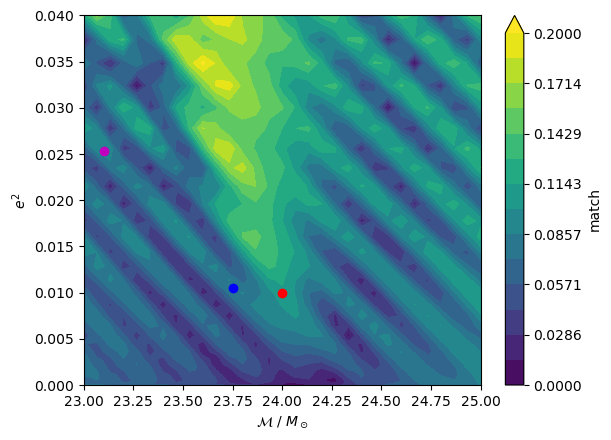

In [164]:
# Load ecc^2 against chirp mass plot
with open(os.path.join('e_sqrd_chirp_data', 'dataslot_8'), 'rb') as fp:
    data = pickle.load(fp)

# Plot data
e_vals = np.linspace(0, 0.2, 31)
chirp_vals = np.linspace(23, 25, 31)
plt.contourf(chirp_vals, e_vals**2, np.array(data['h2'])/np.array(data['h1']), np.linspace(0, 0.2, 15), vmin=0, vmax=0.2, extend='max')
plt.colorbar(label='match')
plt.scatter(24, 0.1**2, c='r', zorder=5)
plt.xlabel('$\mathcal{M}~/~M_\odot$')
plt.ylabel('$e^2$')

# Find two points along stripe manually
plt.scatter(23.75, 0.0105, c='b', zorder=3)
plt.scatter(23.1, 0.0253, c='m', zorder=3)

Let's plot waveforms from five points equally spaced along this line.

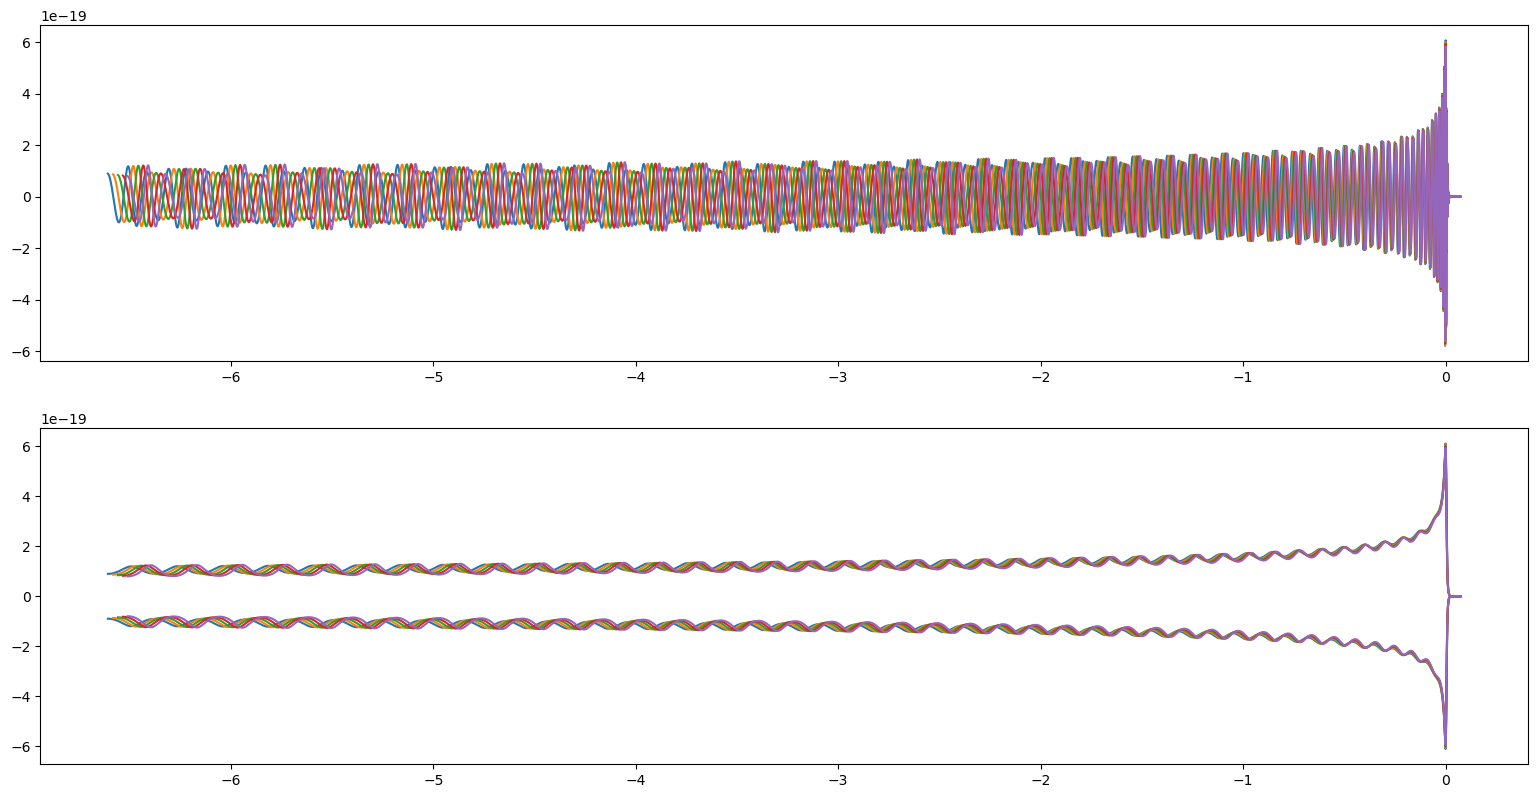

In [64]:
n_points = 5

# Points on line
bright_e2_range = [0.0105, 0.0253]
bright_chirp_range = [23.75, 23.1]
e2_vals = np.linspace(*bright_e2_range, n_points)
chirp_vals = np.linspace(*bright_chirp_range, n_points)
e_vals = np.sqrt(e2_vals)

# Generate and plot waveforms
plt.figure(figsize=(6.4*3,4.8*2))
for i in range(n_points):
    h = gen_wf(10, e_vals[i], chirp2total(chirp_vals[i], 2), 2, 4096, 'TEOBResumS')
    plt.subplot(2,1,1)
    plt.plot(h.sample_times, h, c=f'C{i}', label=f'e: {e_vals[i]:.3f}, chirp: {chirp_vals[i]:.3f}')
    plt.subplot(2,1,2)
    plt.plot(h.sample_times, np.abs(h), c=f'C{i}', label=f'e: {e_vals[i]:.3f}, chirp: {chirp_vals[i]:.3f}')
    plt.plot(h.sample_times, -np.abs(h), c=f'C{i}')

Appears that number of amplitude modulations is equal, such that the modulations line up at the end of the inspiral/merger. Let's now compare with a waveform in a 'dark strip' (i.e. a minimum of the match).

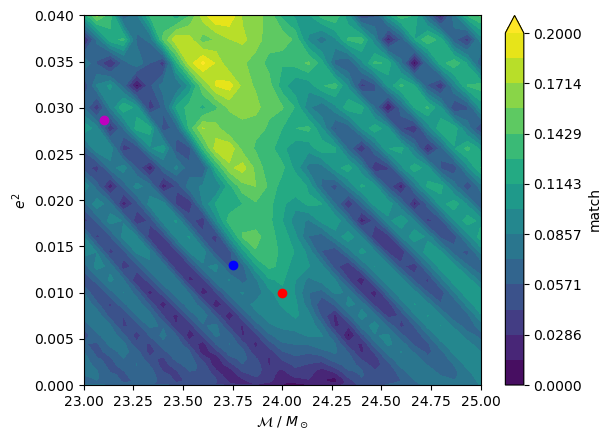

In [163]:
# Load ecc^2 against chirp mass plot
with open(os.path.join('e_sqrd_chirp_data', 'dataslot_8'), 'rb') as fp:
    data = pickle.load(fp)

# Plot data
e_vals = np.linspace(0, 0.2, 31)
chirp_vals = np.linspace(23, 25, 31)
plt.contourf(chirp_vals, e_vals**2, np.array(data['h2'])/np.array(data['h1']), np.linspace(0, 0.2, 15), vmin=0, vmax=0.2, extend='max')
plt.colorbar(label='match')
plt.scatter(24, 0.1**2, c='r', zorder=5)
plt.xlabel('$\mathcal{M}~/~M_\odot$')
plt.ylabel('$e^2$')

# Find two points along stripe manually
plt.scatter(23.75, 0.0130, c='b', zorder=3)
plt.scatter(23.1, 0.0287, c='m', zorder=3)

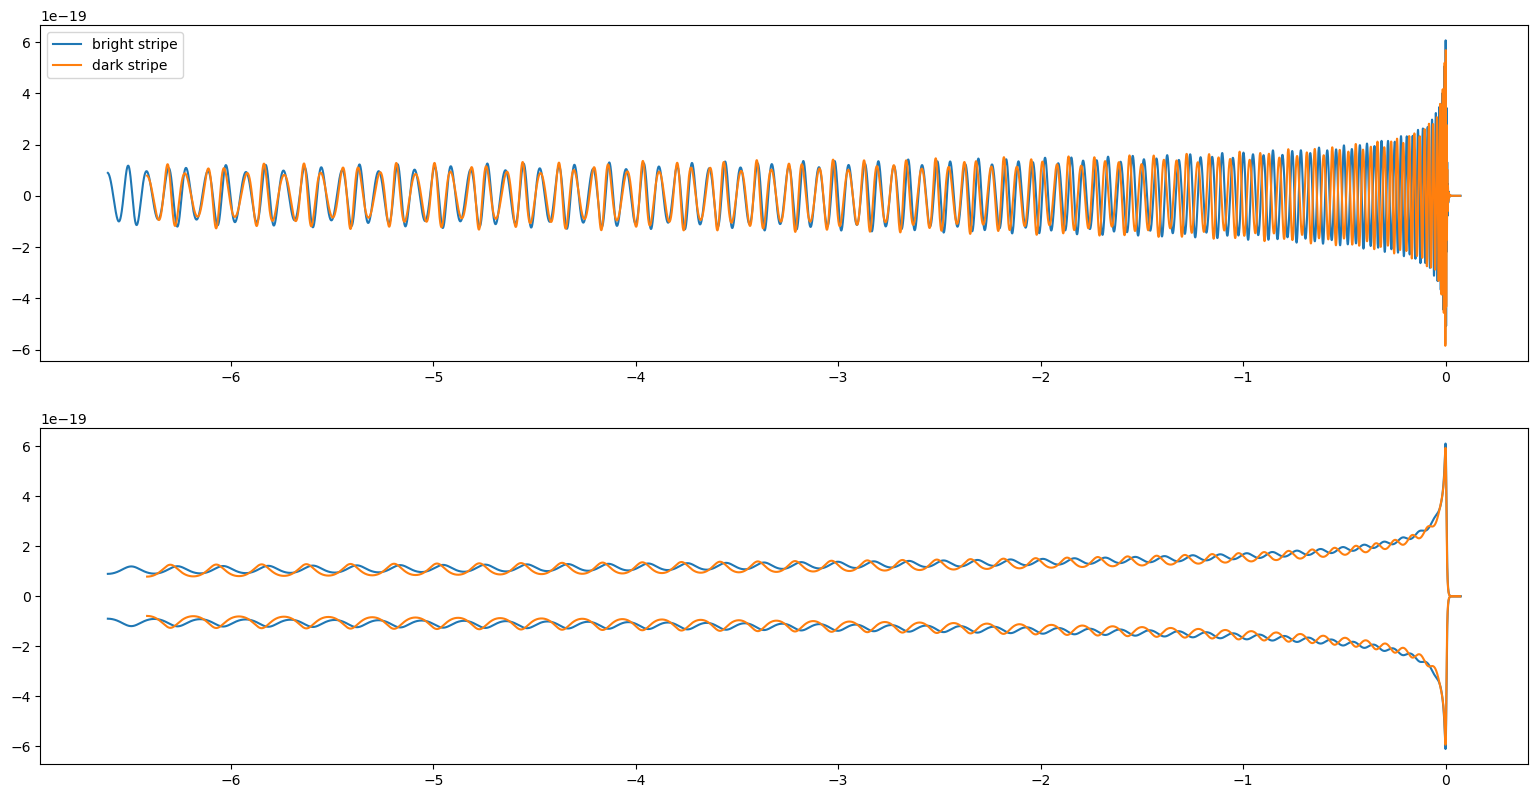

In [145]:
hb = gen_wf(10, 0.0105**0.5, chirp2total(23.75, 2), 2, 4096, 'TEOBResumS')
hd = gen_wf(10, 0.0287**0.5, chirp2total(23.1, 2), 2, 4096, 'TEOBResumS')
plt.figure(figsize=(6.4*3,4.8*2))
plt.subplot(2,1,1)
plt.plot(hb.sample_times, hb, c='C0', label='bright stripe')
plt.plot(hd.sample_times, hd, c='C1', label='dark stripe')
plt.legend()
plt.subplot(2,1,2)
plt.plot(hb.sample_times, np.abs(hb), c='C0')
plt.plot(hb.sample_times, -np.abs(hb), c='C0')
plt.plot(hd.sample_times, np.abs(hd), c='C1')
plt.plot(hd.sample_times, -np.abs(hd), c='C1')

Blue line here is on a bright stripe, orange line on a dark stripe. Although they start close together in amplitude modulations, they are out of phase by the end of inspiral/merger. Interesting to plot also corresponding h2 to this plot here and see how its amplitude modulations line up. Would expect to see that it acts like a waveform on the bright stripe. Will plot n=4, as accuracy of h2 is poor for n=2.

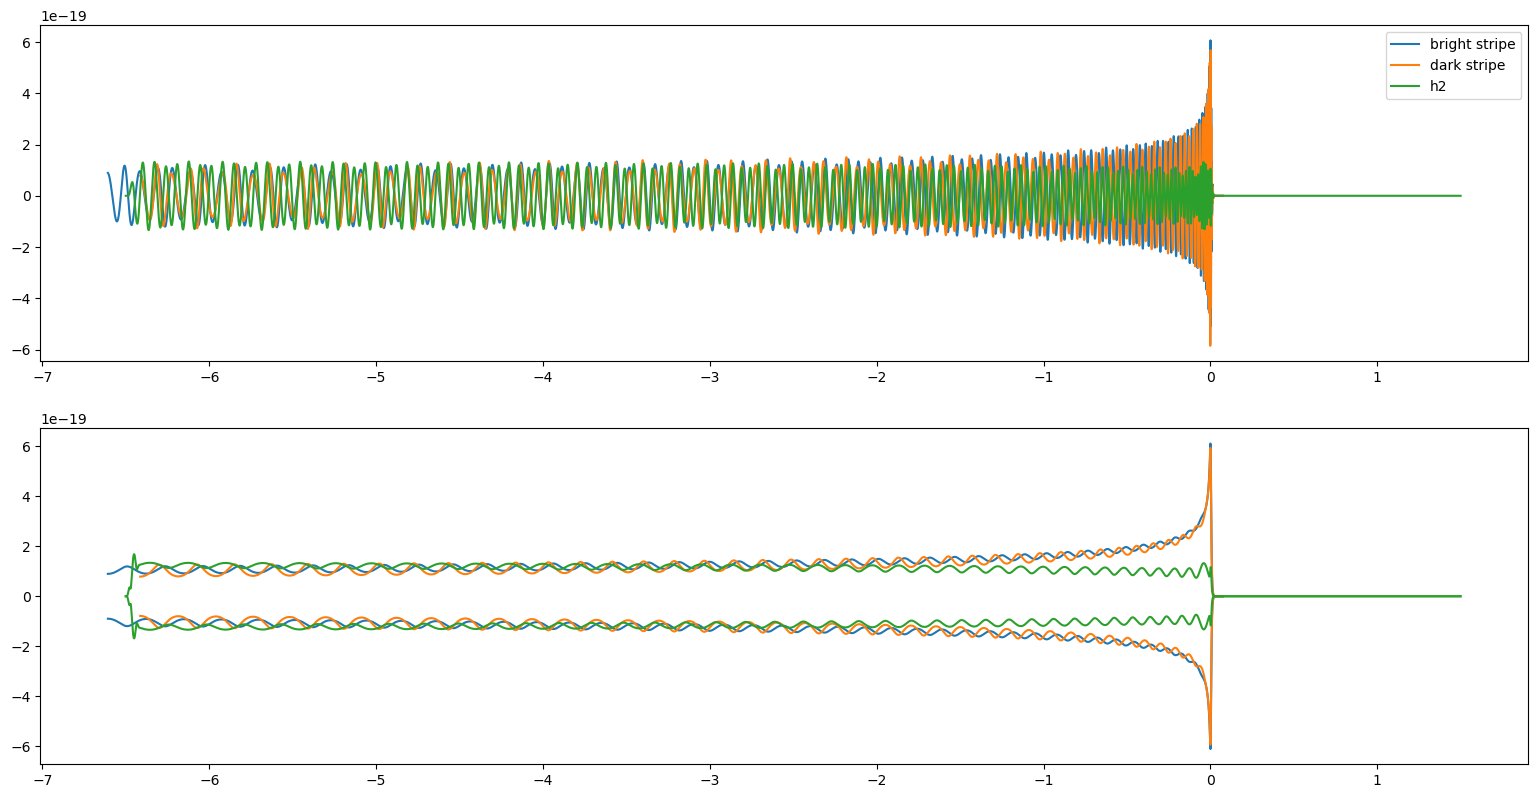

In [144]:
hb = gen_wf(10, 0.0105**0.5, chirp2total(23.75, 2), 2, 4096, 'TEOBResumS')
hd = gen_wf(10, 0.0287**0.5, chirp2total(23.1, 2), 2, 4096, 'TEOBResumS')
_, _, h2, _, _, _, _, _, _ = get_h([1,1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096)
plt.figure(figsize=(6.4*3,4.8*2))
plt.subplot(2,1,1)
plt.plot(hb.sample_times, hb, c='C0', label='bright stripe')
plt.plot(hd.sample_times, hd, c='C1', label='dark stripe')
plt.plot(h2.sample_times, h2*5, c='C2', label='h2')
plt.legend()
plt.subplot(2,1,2)
plt.plot(hb.sample_times, np.abs(hb), c='C0')
plt.plot(hb.sample_times, -np.abs(hb), c='C0')
plt.plot(hd.sample_times, np.abs(hd), c='C1')
plt.plot(hd.sample_times, -np.abs(hd), c='C1')
plt.plot(h2.sample_times, np.abs(h2*5), c='C2')
plt.plot(h2.sample_times, -np.abs(h2*5), c='C2')

Can indeed see that just before merger, the h2 waveform's amplitude modulations do indeed start to line up with the blue waveform on the blue stripe. Finally, want to look at multiple points on different bright stripes, at both lower and higher masses that the fiducial hn waveforms in order to check that the pattern we see does indeed hold true.

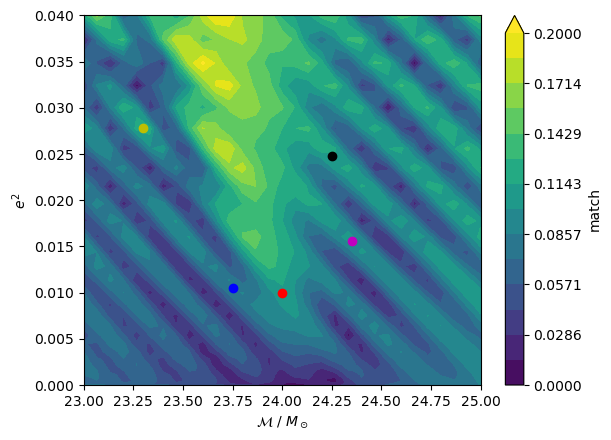

In [162]:
# Load ecc^2 against chirp mass plot
with open(os.path.join('e_sqrd_chirp_data', 'dataslot_8'), 'rb') as fp:
    data = pickle.load(fp)

# Plot data
e_vals = np.linspace(0, 0.2, 31)
chirp_vals = np.linspace(23, 25, 31)
plt.contourf(chirp_vals, e_vals**2, np.array(data['h2'])/np.array(data['h1']), np.linspace(0, 0.2, 15), vmin=0, vmax=0.2, extend='max')
plt.colorbar(label='match')
plt.scatter(24, 0.1**2, c='r', zorder=5)
plt.xlabel('$\mathcal{M}~/~M_\odot$')
plt.ylabel('$e^2$')

# Find points on stripe manually
plt.scatter(23.75, 0.0105, c='b', zorder=3)
plt.scatter(24.35, 0.0156, c='m', zorder=3)
plt.scatter(23.30, 0.0278, c='y', zorder=3)
plt.scatter(24.25, 0.0248, c='k', zorder=3)

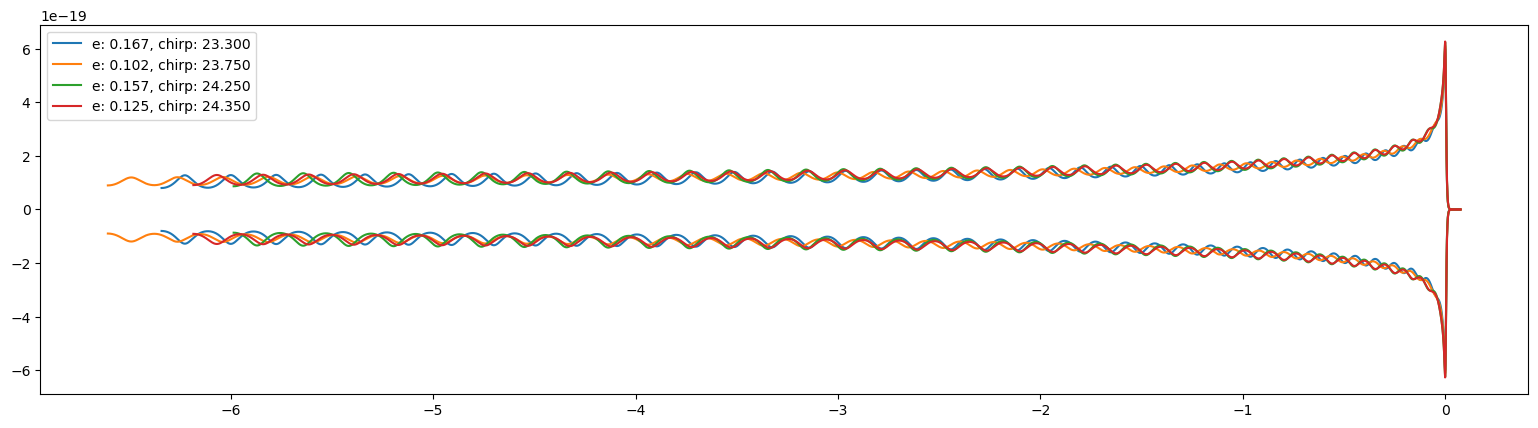

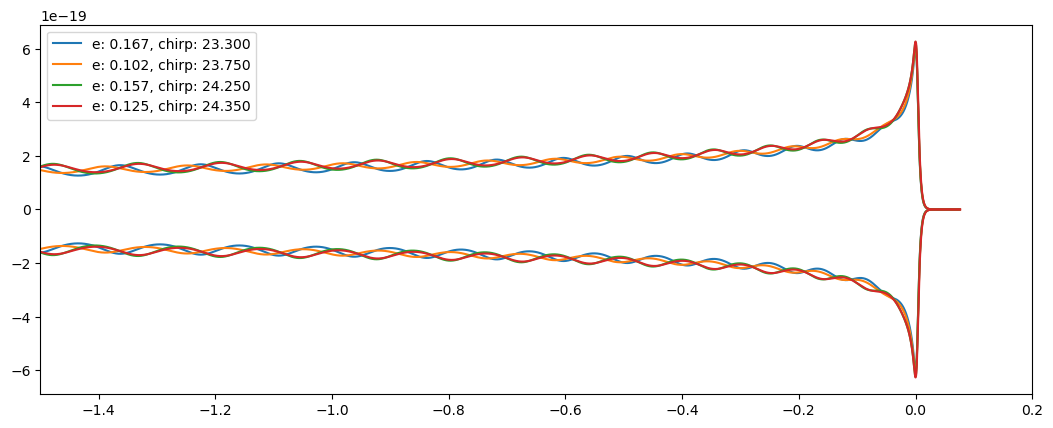

In [120]:
# Points on bright stripes
e2_vals = np.array([0.0278, 0.0105, 0.0248, 0.0156])
chirp_vals = np.array([23.30, 23.75, 24.25, 24.35])
e_vals = np.sqrt(e2_vals)

# Generate and plot waveforms
plt.figure(figsize=(6.4*3, 4.8))
for i in range(len(e_vals)):
    h = gen_wf(10, e_vals[i], chirp2total(chirp_vals[i], 2), 2, 4096, 'TEOBResumS')
    plt.plot(h.sample_times, np.abs(h), c=f'C{i}', label=f'e: {e_vals[i]:.3f}, chirp: {chirp_vals[i]:.3f}')
    plt.plot(h.sample_times, -np.abs(h), c=f'C{i}')
plt.legend()
plt.show()

# Generate and plot waveforms
plt.figure(figsize=(6.4*2, 4.8))
for i in range(len(e_vals)):
    h = gen_wf(10, e_vals[i], chirp2total(chirp_vals[i], 2), 2, 4096, 'TEOBResumS')
    plt.plot(h.sample_times, np.abs(h), c=f'C{i}', label=f'e: {e_vals[i]:.3f}, chirp: {chirp_vals[i]:.3f}')
    plt.plot(h.sample_times, -np.abs(h), c=f'C{i}')
plt.xlim(-1.5,0.2)
plt.legend()
plt.show()

This perhaps not what we expect. Although all lines have similar amplitude modulations in the middle of this signal, the red, green lines are out of phasewith blue, orange lines at the crucial just before merger point. Only connection between these is the chirp mass - is the phasing requirement perhaps different for chirp masses higher than the fiducial waveform?

Let's try picking one eccentricity: 0.1, and plotting waveform for every chirp mass with this eccentricity that lies on a bright stripe. As it is hard to see stripes close to the fiducial waveform's chirp mass, let's plot h2 here instead.

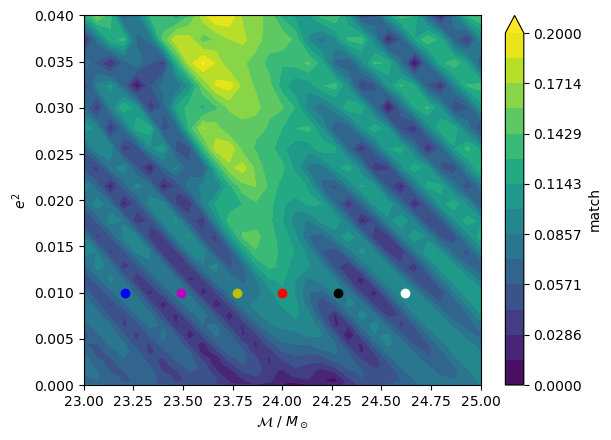

In [161]:
# Load ecc^2 against chirp mass plot
with open(os.path.join('e_sqrd_chirp_data', 'dataslot_8'), 'rb') as fp:
    data = pickle.load(fp)

# Plot data
e_vals = np.linspace(0, 0.2, 31)
chirp_vals = np.linspace(23, 25, 31)
plt.contourf(chirp_vals, e_vals**2, np.array(data['h2'])/np.array(data['h1']), np.linspace(0, 0.2, 15), vmin=0, vmax=0.2, extend='max')
plt.colorbar(label='match')
plt.scatter(24, 0.1**2, c='r', zorder=5)
plt.xlabel('$\mathcal{M}~/~M_\odot$')
plt.ylabel('$e^2$')

# Find points on stripe manually
plt.scatter(23.21, 0.01, c='b', zorder=3)
plt.scatter(23.49, 0.01, c='m', zorder=3)
plt.scatter(23.77, 0.01, c='y', zorder=3)
plt.scatter(24.28, 0.01, c='k', zorder=3)
plt.scatter(24.62, 0.01, c='w', zorder=3)

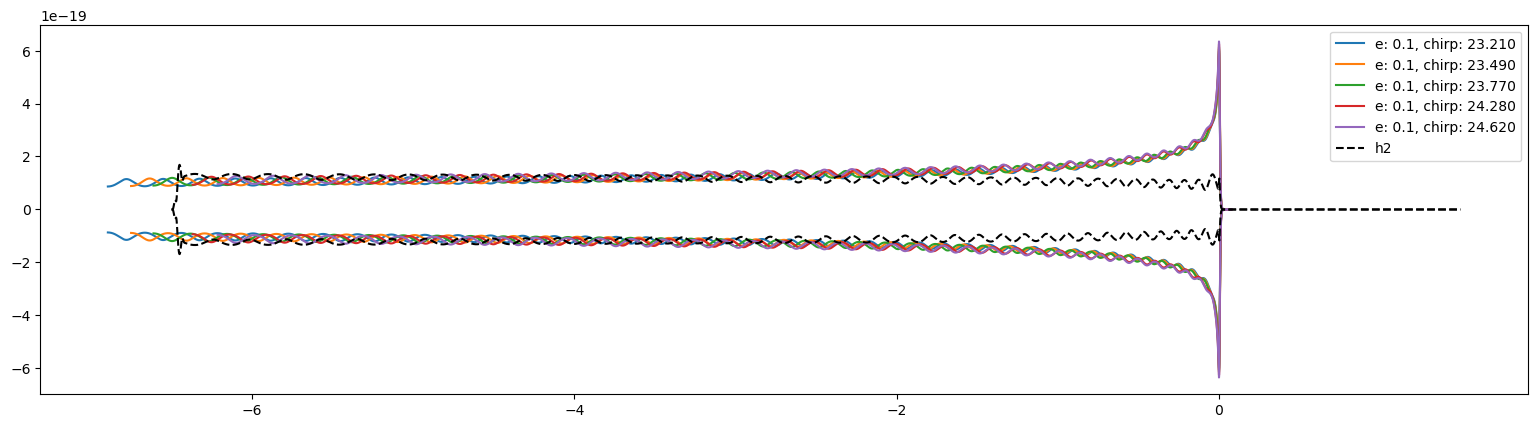

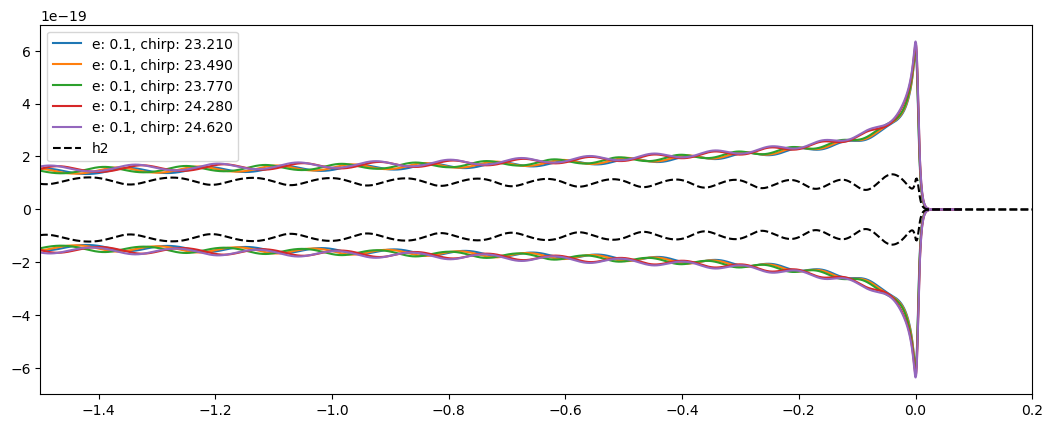

In [137]:
# Points on bright stripes with e=0.1
chirp_vals = np.array([23.21, 23.49, 23.77, 24.28, 24.62])

# Generate and plot waveforms
plt.figure(figsize=(6.4*3, 4.8))
for i in range(len(chirp_vals)):
    h = gen_wf(10, 0.1, chirp2total(chirp_vals[i], 2), 2, 4096, 'TEOBResumS')
    plt.plot(h.sample_times, np.abs(h), c=f'C{i}', label=f'e: 0.1, chirp: {chirp_vals[i]:.3f}')
    plt.plot(h.sample_times, -np.abs(h), c=f'C{i}')
_, _, h2, _, _, _, _, _, _ = get_h([1,1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096)
plt.plot(h2.sample_times, np.abs(h2*5), c='k', ls='dashed', label='h2')
plt.plot(h2.sample_times, -np.abs(h2*5), c='k', ls='dashed')
plt.legend()
plt.show()

# Generate and plot waveforms
plt.figure(figsize=(6.4*2, 4.8))
for i in range(len(chirp_vals)):
    h = gen_wf(10, 0.1, chirp2total(chirp_vals[i], 2), 2, 4096, 'TEOBResumS')
    plt.plot(h.sample_times, np.abs(h), c=f'C{i}', label=f'e: 0.1, chirp: {chirp_vals[i]:.3f}')
    plt.plot(h.sample_times, -np.abs(h), c=f'C{i}')
_, _, h2, _, _, _, _, _, _ = get_h([1,1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096)
plt.plot(h2.sample_times, np.abs(h2*5), c='k', ls='dashed', label='h2')
plt.plot(h2.sample_times, -np.abs(h2*5), c='k', ls='dashed')
plt.xlim(-1.5,0.2)
plt.legend()
plt.show()

Again separated into two groups: those with chirp masses lower than hn wfs, and those with chirp masses higher. It appears that the h2 waveform lines up fairly well with the lower group here before merger, however this is not perfect. One possible hypothesis is that the amplitude modulations here can be either in phase of 180 degrees out of phase in order to match well and be on a bright stripe. This is consistent with the comparison earlier with a point on a dark stripe, which was not exactly 180 degrees out of phase. Further support for this is that the amplitude modulations of a waveform generated at e=0.1, chirp=24 has amplitude modulations similar to the red/purple group, i.e. 180 degrees out of phase with the h2 waveform made from it.

Let's now plot waveforms for points between two successive stripes (still fixing ecc, varying just chirp mass), and see how amplitude modulations here vary from one stripe to the next).

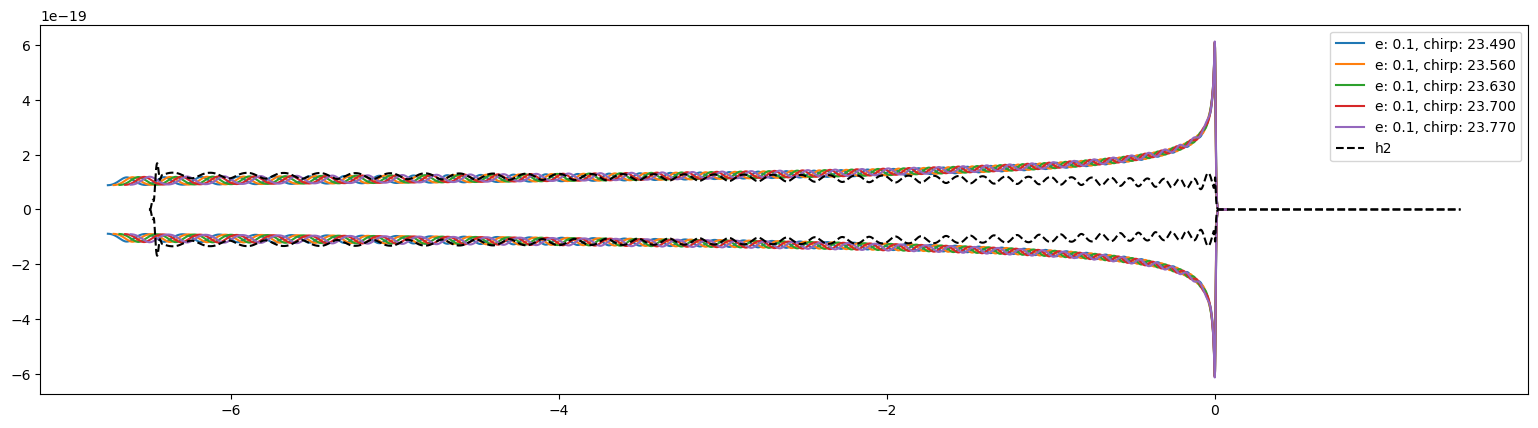

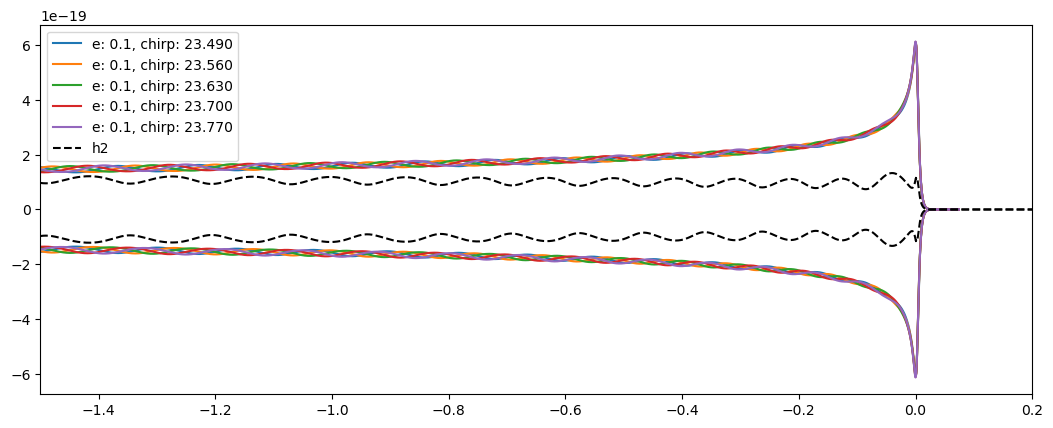

In [150]:
# Points on bright stripes with e=0.1
chirp_vals = np.linspace(23.49, 23.77, 5)

# Generate and plot waveforms
plt.figure(figsize=(6.4*3, 4.8))
for i in range(len(chirp_vals)):
    h = gen_wf(10, 0.1, chirp2total(chirp_vals[i], 2), 2, 4096, 'TEOBResumS')
    plt.plot(h.sample_times, np.abs(h), c=f'C{i}', label=f'e: 0.1, chirp: {chirp_vals[i]:.3f}')
    plt.plot(h.sample_times, -np.abs(h), c=f'C{i}')
_, _, h2, _, _, _, _, _, _ = get_h([1,1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096)
plt.plot(h2.sample_times, np.abs(h2*5), c='k', ls='dashed', label='h2')
plt.plot(h2.sample_times, -np.abs(h2*5), c='k', ls='dashed')
plt.legend()
plt.show()

# Generate and plot waveforms
plt.figure(figsize=(6.4*2, 4.8))
for i in range(len(chirp_vals)):
    h = gen_wf(10, 0.1, chirp2total(chirp_vals[i], 2), 2, 4096, 'TEOBResumS')
    plt.plot(h.sample_times, np.abs(h), c=f'C{i}', label=f'e: 0.1, chirp: {chirp_vals[i]:.3f}')
    plt.plot(h.sample_times, -np.abs(h), c=f'C{i}')
_, _, h2, _, _, _, _, _, _ = get_h([1,1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096)
plt.plot(h2.sample_times, np.abs(h2*5), c='k', ls='dashed', label='h2')
plt.plot(h2.sample_times, -np.abs(h2*5), c='k', ls='dashed')
plt.xlim(-1.5,0.2)
plt.legend()
plt.show()

We see that the full range of possible amplitude modulations are covered here, so simply being exactly 0 or 180 degrees in phase cannot be the full story. Looking at the ecc^2 against chirp plot, it appears that bright stripes become dark stripes when crossing the degeneracy, and vice versa, supporting the 'flip' that we see here. The ecc^2 against chirp plots of cos(phase difference) however do not support this flip, showing a constant 'sign' across the degeneracy line.

Let's try plotting the array of points at e=0.1 which lie on bright stripes in h2/h1 onto the ecc^2 against chirp mass plot of cos(diff_phase), and see where they lie here.

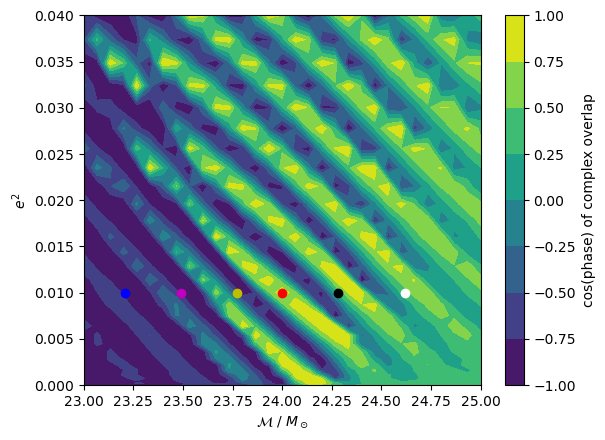

In [166]:
# Load ecc^2 against chirp mass plot
with open(os.path.join('e_sqrd_chirp_data', 'dataslot_8'), 'rb') as fp:
    data = pickle.load(fp)

# Plot data
e_vals = np.linspace(0, 0.2, 31)
chirp_vals = np.linspace(23, 25, 31)
plt.contourf(chirp_vals, e_vals**2, np.cos(np.array(data['diff_phase'])))
plt.colorbar(label='cos(phase) of complex overlap')
plt.scatter(24, 0.1**2, c='r', zorder=5)
plt.xlabel('$\mathcal{M}~/~M_\odot$')
plt.ylabel('$e^2$')

# Find points on stripe manually
plt.scatter(23.21, 0.01, c='b', zorder=3)
plt.scatter(23.49, 0.01, c='m', zorder=3)
plt.scatter(23.77, 0.01, c='y', zorder=3)
plt.scatter(24.28, 0.01, c='k', zorder=3)
plt.scatter(24.62, 0.01, c='w', zorder=3)

See that the first set are now on the upper-right boundary of the bright stripes, and the second set on the lower-left boundary. Note that the bright stripes here correspond to both matches being in phase, so let's see the values of each match.

In [8]:
# Points on bright stripes with e=0.1
chirp_vals = np.array([23.21, 23.49, 23.77, 24.28, 24.62])

# Calculate matches
_, h1, h2, _, _, _, _, _, _ = get_h([1,1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096)
for i in range(len(chirp_vals)):
    h = gen_wf(10, 0.1, chirp2total(chirp_vals[i], 2), 2, 4096, 'TEOBResumS')
    matches = match_hn([h1, h2], h, 10)
    h1_match = np.angle(matches[0])
    h2_match = np.angle(matches[1])
    diff_match = h1_match-h2_match
    while diff_match < -np.pi:
        diff_match += 2*np.pi
    while diff_match > +np.pi:
        diff_match -= 2*np.pi
    print(f'h1 match angle: {h1_match}, h2 match angle: {h2_match}, h1-h2 angle: {diff_match}')

h1 match angle: 0.4092009568277228, h2 match angle: -2.2152723698193397, h1-h2 angle: 2.6244733266470623
h1 match angle: -0.997666219670013, h2 match angle: 2.7350903253449443, h1-h2 angle: 2.550428762164629
h1 match angle: -1.8578197383796629, h2 match angle: 2.148609525458552, h1-h2 angle: 2.276756043341371
h1 match angle: 0.060333914875706454, h2 match angle: 1.3548364401473147, h1-h2 angle: -1.2945025252716083
h1 match angle: -2.3336647543750337, h2 match angle: -1.0492809673787844, h1-h2 angle: -1.2843837869962493


We see here that for the first set, the h1 match leads by ~2.5 radians, whereas for the second set the h2 match leads by ~1.3 radians.

# Low mass

Due to (fairly) high mass of the parameters used above, the majority of the power is expected to be just before merger, and so is likely why the amplitude modulations line up here along a bright stripe. Taking a look at the e_10 = 0.1, chirp = 10 plots, see that while there are no obvious stripes in the quad match (or at the very least heavily suppressed), there are (fainter) curved 'stripes' in the h2/h1 plot. Would be interesting to plot several points along one of these and see where the waveform amplitude modulations overlap here.

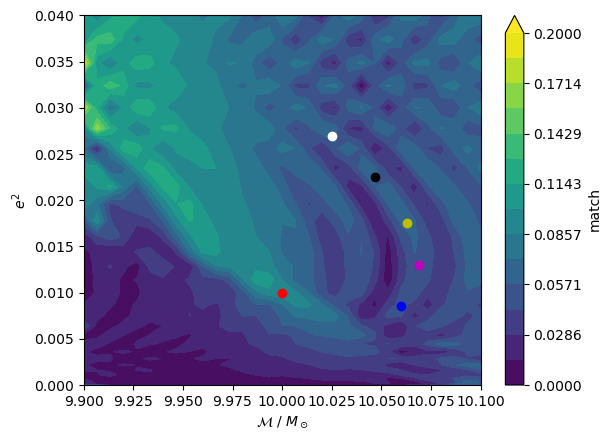

In [36]:
# Load ecc^2 against chirp mass plot
with open(os.path.join('e_sqrd_chirp_data', 'dataslot_10'), 'rb') as fp:
    data = pickle.load(fp)[1][0]

# Plot data
e_vals = np.linspace(0, 0.2, 31)
chirp_vals = np.linspace(9.9, 10.1, 31)
plt.contourf(chirp_vals, e_vals**2, np.array(data['h2'])/np.array(data['h1']), np.linspace(0, 0.2, 15), vmin=0, vmax=0.2, extend='max')
plt.colorbar(label='match')
plt.scatter(10, 0.1**2, c='r', zorder=5)
plt.xlabel('$\mathcal{M}~/~M_\odot$')
plt.ylabel('$e^2$')

# Find points on stripe manually
plt.scatter(10.06, 0.0085, c='b', zorder=3)
plt.scatter(10.069, 0.013, c='m', zorder=3)
plt.scatter(10.063, 0.0175, c='y', zorder=3)
plt.scatter(10.047, 0.0225, c='k', zorder=3)
plt.scatter(10.025, 0.027, c='w', zorder=3)

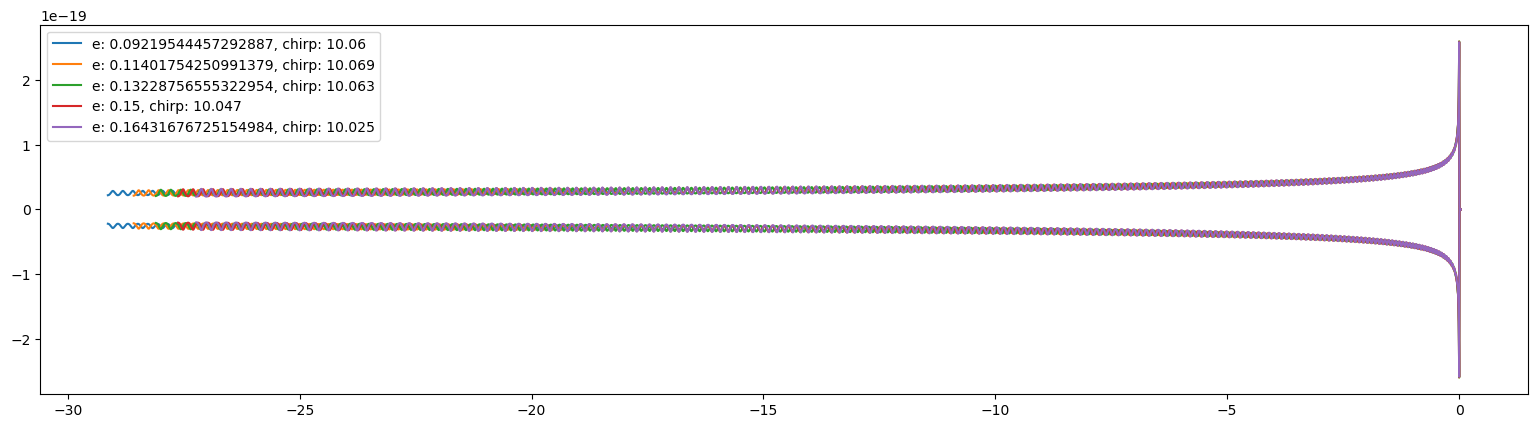

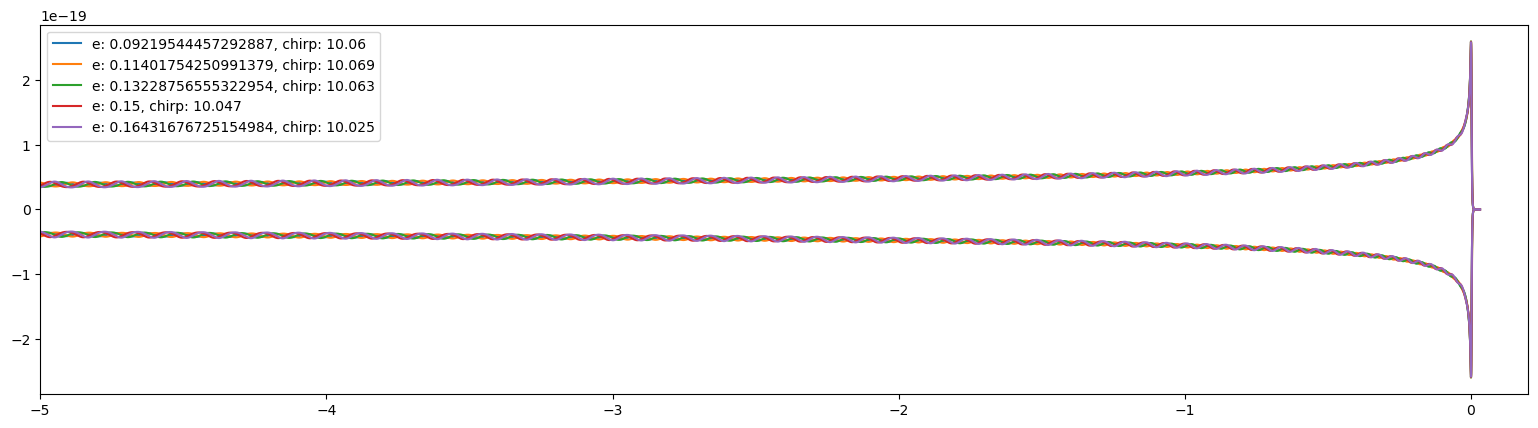

In [38]:
# Points on bright stripes
e2_vals = np.array([0.0085, 0.013, 0.0175, 0.0225, 0.027])
chirp_vals = np.array([10.06, 10.069, 10.063, 10.047, 10.025])
e_vals = np.sqrt(e2_vals)

# Generate and plot waveforms
plt.figure(figsize=(6.4*3, 4.8))
for i in range(len(e_vals)):
    h = gen_wf(10, e_vals[i], chirp2total(chirp_vals[i], 2), 2, 4096, 'TEOBResumS')
    plt.plot(h.sample_times, np.abs(h), c=f'C{i}', label=f'e: {e_vals[i]}, chirp: {chirp_vals[i]}')
    plt.plot(h.sample_times, -np.abs(h), c=f'C{i}')
plt.legend()
plt.show()

# Generate and plot waveforms
plt.figure(figsize=(6.4*3, 4.8))
for i in range(len(e_vals)):
    h = gen_wf(10, e_vals[i], chirp2total(chirp_vals[i], 2), 2, 4096, 'TEOBResumS')
    plt.plot(h.sample_times, np.abs(h), c=f'C{i}', label=f'e: {e_vals[i]}, chirp: {chirp_vals[i]}')
    plt.plot(h.sample_times, -np.abs(h), c=f'C{i}')
plt.xlim(-5,0.2)
plt.legend()
plt.show()

Clearly do not line up at merger anymore, but it is hard to tell where they do. Where is the majority of the power located here? One approach is to find the 'average' frequency using **(-14/3) like we did for the line of degeneracy, and see when the waveform reaches this point.

In [66]:
# Generate waveform at given point to use in sigmasq
h = gen_wf(10, 0.1, chirp2total(10, 2), 2, 4096, 'TEOBResumS')
h.resize(ceiltwo(len(h)))

# Generate the aLIGO ZDHP PSD
psd, _ = gen_psd(h, 10)

# Calculate both integrals using sigmasq
h = h.real().to_frequencyseries()
ss = sigmasq(h, psd=psd, low_frequency_cutoff=10+3)
ssf = sigmasq(h*h.sample_frequencies**(-7/3), psd=psd, low_frequency_cutoff=10+3)

# Use average frequency to evolve eccentricities
avg_f = (ssf/ss)**(-3/14)
print('Average frequency: '+str(avg_f)+' Hz')
s_e = shifted_e(avg_f, 10, 0.1)
print(f'Given_e shifted from {0.1} to {s_e}')

# Create new waveform with shifted params and calculate duration
s = gen_wf(avg_f, s_e, chirp2total(10, 2), 2, 4096, 'TEOBResumS')
print(f'Average power located at -{s.duration} seconds')

Average frequency: 30.389699600612165 Hz
Given_e shifted from 0.1 to 0.03093538028570766
Average power located at -1.494140625 seconds


This has clearly not helped.

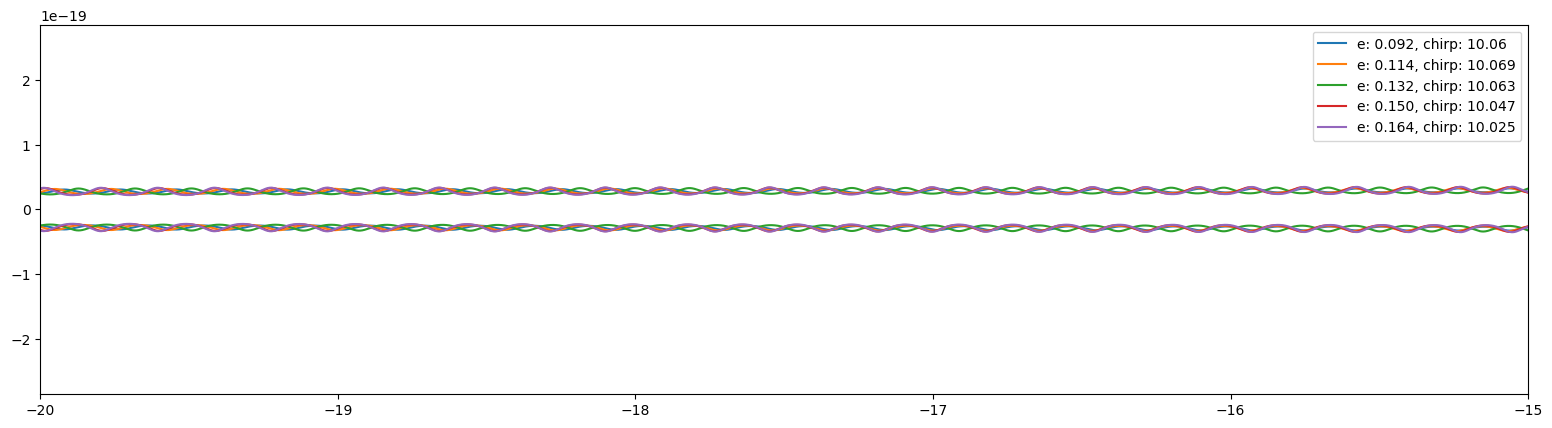

In [55]:
# Generate and plot waveforms
plt.figure(figsize=(6.4*3, 4.8))
for i in range(len(e_vals)):
    h = gen_wf(10, e_vals[i], chirp2total(chirp_vals[i], 2), 2, 4096, 'TEOBResumS')
    plt.plot(h.sample_times, np.abs(h), c=f'C{i}', label=f'e: {e_vals[i]:.3f}, chirp: {chirp_vals[i]}')
    plt.plot(h.sample_times, -np.abs(h), c=f'C{i}')
plt.xlim(-20,-15)
plt.legend()
plt.show()

All lines appear to line up here with the exception of green, which is 180 degrees out of phase. Due to grid resolution, cannot rule out possibility that patterns on ecc^2 against chirp plot could be misleading - e.g. above curved part of stripe simple see crossing pattern, with no way to tell which way stripes are actually going here (or if both are true?).

# Moving amplitude modulations

We had so far assumed that simple shifting the amplitude modulations of the component waveforms, i.e. by shifiting their frequency and eccentricity to start earlier, we would also be shifting the h1,...,hn waveforms made up from them. This does not appear to always be the case. Let's start with n=2, and see which parameters this technique works for.

In [6]:
def match_true_anomaly_test(wf_h, n, f_low, e, M, q, sample_rate, approximant, final_match):
    """
    Calculates match between two waveforms, maximised over shifted frequency 
    by calculating the true anomaly using matches to h1,...,hn waveforms.

    Parameters:
        wf_h: Fiducial waveform.
        n: Number of waveform components to use.
        f_low: Starting frequency of waveforms.
        e: Eccentricity of trial waveform.
        M: Total mass of trial waveform.
        q: Mass ratio of trial waveform.
        sample_rate: Sample rate of trial waveform.
        approximant: Approximant of trial waveform.
        final_match: Whether to perform final match to TEOBResumS waveform or h1,...,hn quad match.
        
    Returns:
        Complex match between waveforms maximised over shifted frequency/true anomaly.
    """

    # Calculates matches to h1,...,hn at f_low
    all_wfs = list(get_h([1]*n, f_low, e, M, q, sample_rate, approximant=approximant))
    matches = match_hn(all_wfs[1:n+1], wf_h, f_low)

    # Plot waveforms before for testing
    plt.plot(wf_h.sample_times, abs(wf_h), label='h wf')
    for i, wf in enumerate(all_wfs[1:3]):
        scale = np.mean(abs(wf_h[1000:10000]))/np.mean(abs(wf[1000:10000]))
        plt.plot(wf.sample_times, abs(wf)*scale, label=f'h{i+1}')
    plt.xlim(all_wfs[1].sample_times[0], all_wfs[1].sample_times[0]+2)
    plt.ylim(0*np.mean(abs(wf_h[1000:10000])), 2*np.mean(abs(wf_h[1000:10000])))
    plt.legend()
    plt.show()

    # Gets phase difference
    phase_diff = np.angle(matches[0]) - np.angle(matches[1])
    if phase_diff > 0:
        phase_diff -= 2*np.pi

    # Print for testing
    print(abs(np.array(matches)))
    print(phase_diff)

    # Converts phase difference to shifted frequency and eccentricity
    s_f_range = f_low - shifted_f(f_low, e, M, q)
    s_f = f_low + (phase_diff/(2*np.pi))*s_f_range
    s_e = shifted_e(s_f, f_low, e)
    print(s_f, s_e)

    # Calculates match(es) to final_match at shifted frequency
    if final_match == 'TEOB':
        wf_s_f = gen_wf(s_f, s_e, M, q, sample_rate, approximant)
        m_amp, m_phase =  match_wfs(wf_s_f, wf_h, f_low, True, return_phase=True)
        match = m_amp*np.e**(1j*m_phase)
    elif final_match == 'quad':
        all_s_f_wfs = list(get_h([1]*n, s_f, s_e, M, q, sample_rate, approximant=approximant, comp_phase=-phase_diff))
        match = match_hn(all_s_f_wfs[1:n+1], wf_h, f_low)
    else:
        raise Exception('final_match not recognised')

    # Plot waveforms after for testing
    plt.plot(wf_h.sample_times, abs(wf_h), label='h wf')
    for i, wf in enumerate(all_s_f_wfs[1:3]):
        scale = np.mean(abs(wf_h[1000:10000]))/np.mean(abs(wf[1000:10000]))
        plt.plot(wf.sample_times, abs(wf)*scale, label=f'h{i+1}')
    plt.xlim(all_s_f_wfs[1].sample_times[0], all_s_f_wfs[1].sample_times[0]+2)
    plt.ylim(0*np.mean(abs(wf_h[1000:10000])), 2*np.mean(abs(wf_h[1000:10000])))
    plt.legend()
    plt.show()

    print(abs(np.array(match)))

    # Returns match(es)
    return match

## n=2

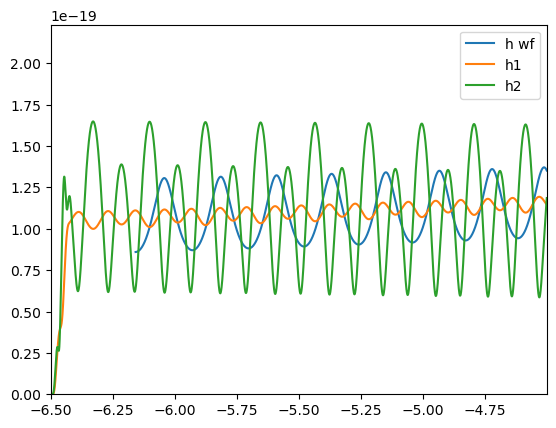

[0.97094522 0.10462019]
-1.5716613491160436
9.966929054702847 0.10035027272622031


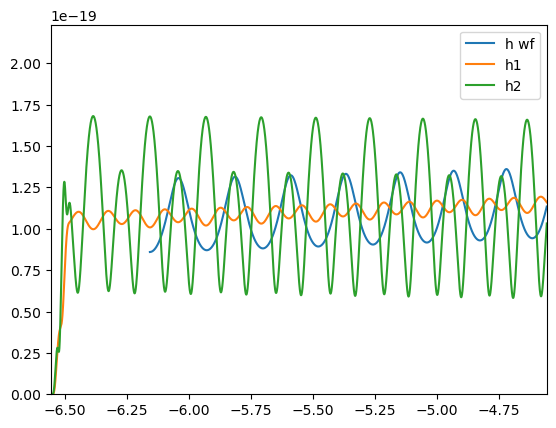

[0.97122809 0.13941648]


In [82]:
h = gen_wf(10, 0.15, chirp2total(24, 2), 2, 4096, 'TEOBResumS')
a = match_true_anomaly_test(h, 2, 10, 0.1, chirp2total(24, 2), 2, 4096, 'TEOBResumS', 'quad')

Both h1 and h2 have shifted here. Let's check other masses (chirp=3,10,50).

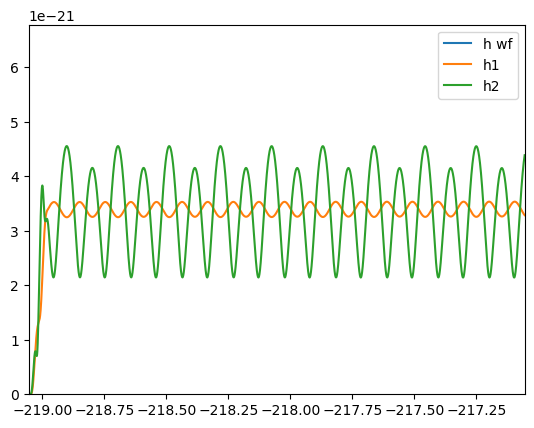

[0.73152481 0.02631058]
-1.287663366787922
9.99924039415134 0.1000080186877592


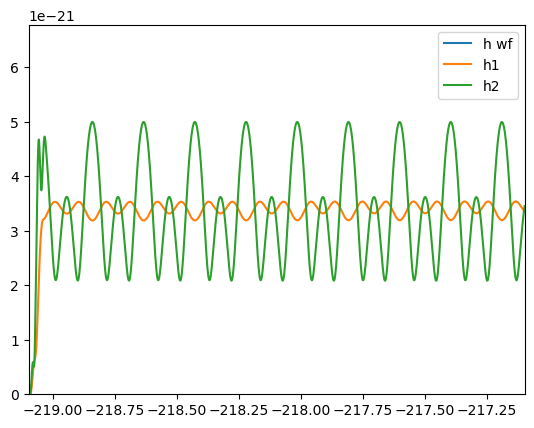

[0.73282792 0.0529713 ]


In [86]:
h = gen_wf(10, 0.15, chirp2total(3, 2), 2, 4096, 'TEOBResumS')
a = match_true_anomaly_test(h, 2, 10, 0.1, chirp2total(3, 2), 2, 4096, 'TEOBResumS', 'quad')

Although we cannot see the signal to compare against here, it is clear that this has not quite worked correctly as the amplitude modulations do not start at the same place at the start of the signal.

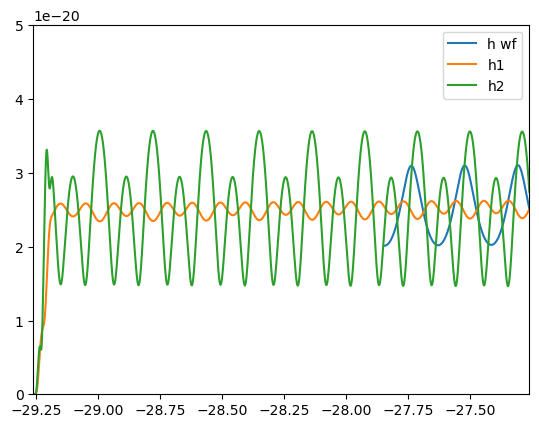

[0.9212451  0.06185342]
-5.908353106178963
9.972931964343168 0.10028651521735227


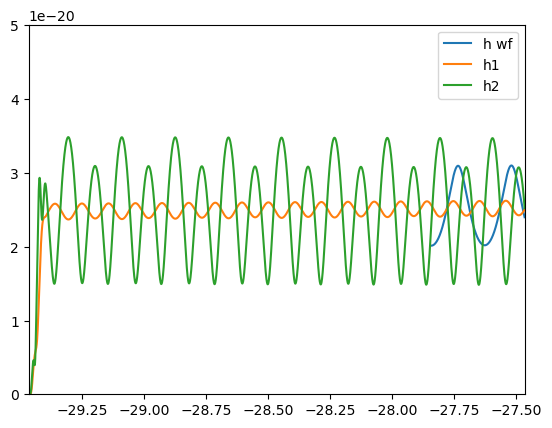

[0.92114501 0.06847128]


In [84]:
h = gen_wf(10, 0.15, chirp2total(10, 2), 2, 4096, 'TEOBResumS')
a = match_true_anomaly_test(h, 2, 10, 0.1, chirp2total(10, 2), 2, 4096, 'TEOBResumS', 'quad')

Although the amplitude modulations have shifted here, it seems that the modulations are slightly different at the start with the first peak being large instead of small. As the different size peaks disappear for n>2, it is unclear whether this is important or simply a consequence of an inaccurate h2.

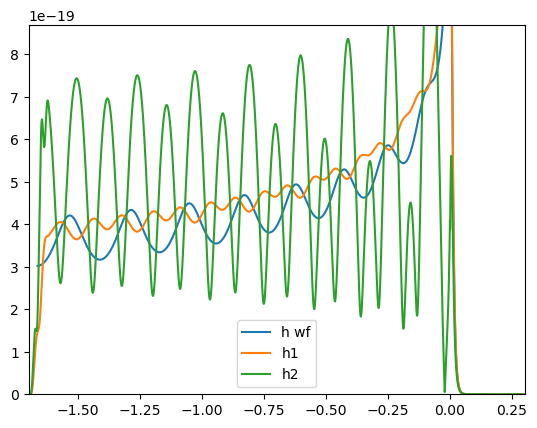

[0.98410936 0.11545275]
-5.240153358914453
9.585259631894298 0.10457265288307414


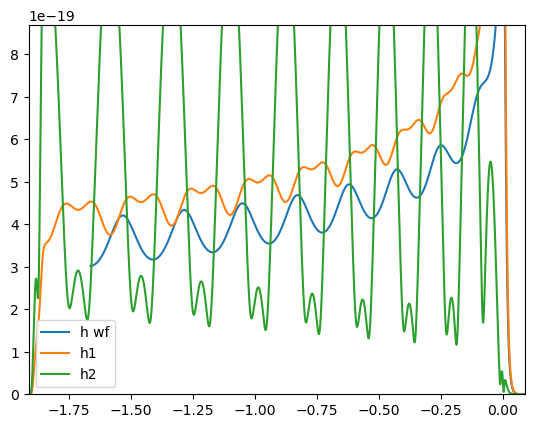

[0.98756051 0.13638595]


In [87]:
h = gen_wf(10, 0.12, chirp2total(50, 2), 2, 4096, 'TEOBResumS')
a = match_true_anomaly_test(h, 2, 10, 0.1, chirp2total(50, 2), 2, 4096, 'TEOBResumS', 'quad')

Does not appear to have shifted amplitude modulations (apart from swap in small/big peaks), although again hard to tell how much inaccuracy of h2 plays a role here.

## n=3

Let's now move to the n=3 case and repeat the same parameters.

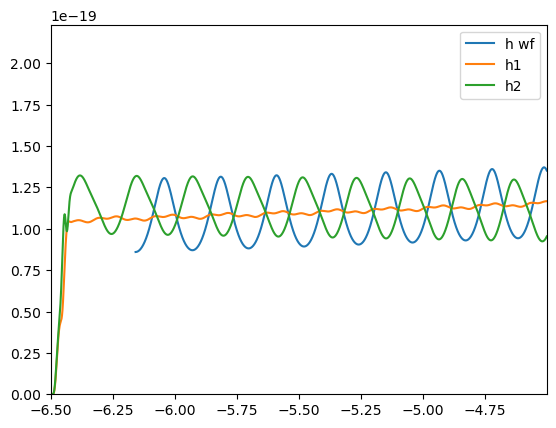

[0.97131527 0.12833244 0.06811154]
-1.6696447829583274
9.96486728434599 0.10037218921215581


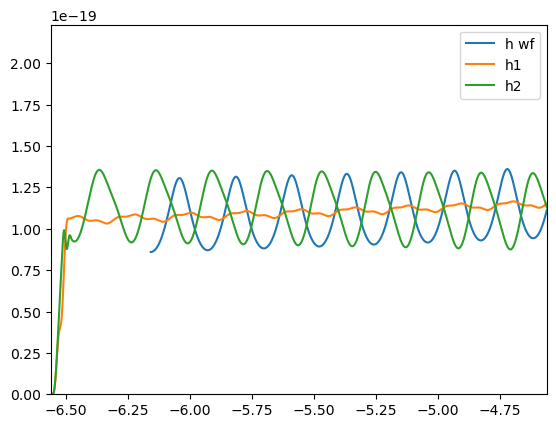

[0.97157569 0.12450797 0.07100435]


In [7]:
h = gen_wf(10, 0.15, chirp2total(24, 2), 2, 4096, 'TEOBResumS')
a = match_true_anomaly_test(h, 3, 10, 0.1, chirp2total(24, 2), 2, 4096, 'TEOBResumS', 'quad')

Amplitude modulations do not shift here.

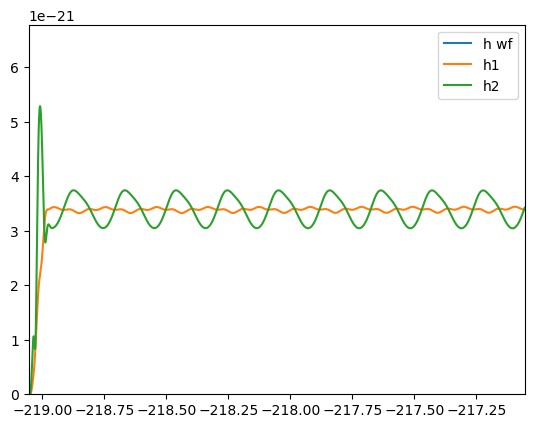

[0.73191678 0.04107505 0.07058219]
-0.7713337840101233
9.999544982276644 0.10000480318948211


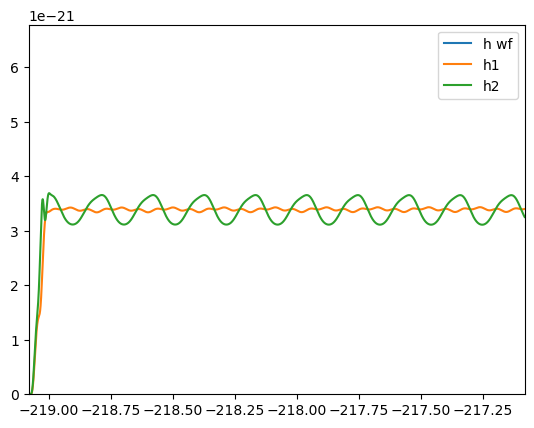

[0.73200012 0.0104472  0.06254603]


In [93]:
h = gen_wf(10, 0.15, chirp2total(3, 2), 2, 4096, 'TEOBResumS')
a = match_true_anomaly_test(h, 3, 10, 0.1, chirp2total(3, 2), 2, 4096, 'TEOBResumS', 'quad')

Amplitude modulations do not shift here.

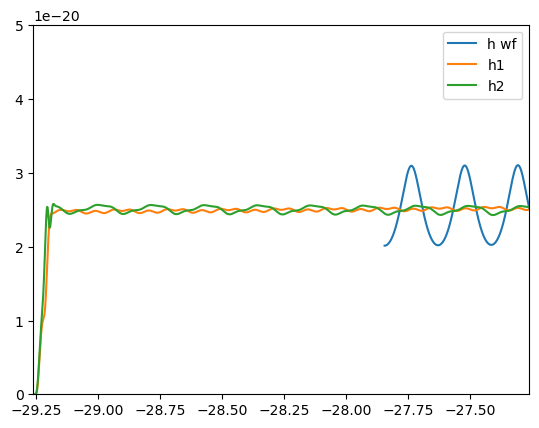

[0.92139209 0.06385184 0.01861024]
-5.930226558419159
9.9728317551352 0.10028757890200918


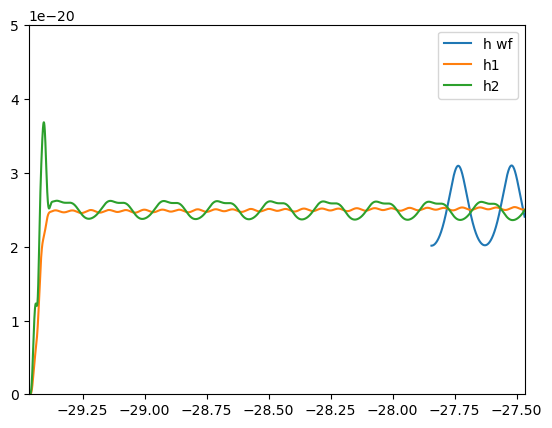

[0.92136162 0.06119725 0.05056068]


In [91]:
h = gen_wf(10, 0.15, chirp2total(10, 2), 2, 4096, 'TEOBResumS')
a = match_true_anomaly_test(h, 3, 10, 0.1, chirp2total(10, 2), 2, 4096, 'TEOBResumS', 'quad')

Amplitude modulations do shift, but not quite in expected way - still start at different point initially.

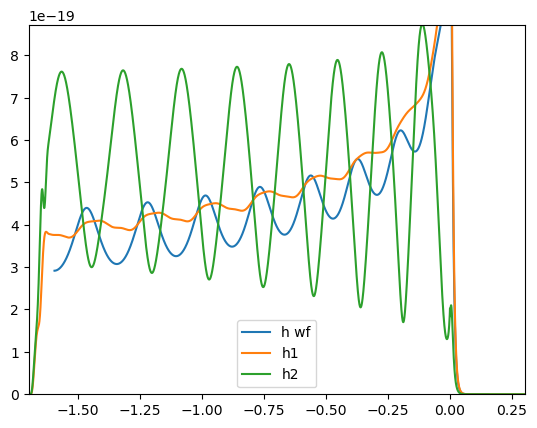

[0.98131069 0.1502406  0.01105861]
-3.5922750686018885
9.71568361033664 0.10309142923198987


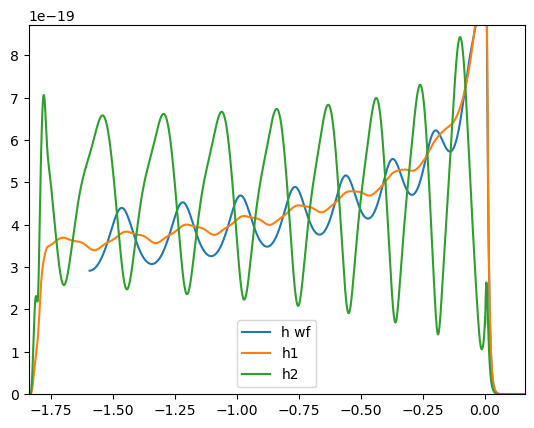

[0.98153042 0.14323366 0.01912366]


In [90]:
h = gen_wf(10, 0.15, chirp2total(50, 2), 2, 4096, 'TEOBResumS')
a = match_true_anomaly_test(h, 3, 10, 0.1, chirp2total(50, 2), 2, 4096, 'TEOBResumS', 'quad')

Amplitude modulations do not shift here.

It is clear enough now that while it kind of works (tentatively) for some parameters (i.e. e=0.1, chirp=24) for n=2, this does not work at all at n=3 (and presumably higher as well).

# h2 amplitude modulation size

We see varying size of amplitude modulation of h2 (and others) when shifting the true anomaly of components. One possible idea is that this is related to differing distances between peaks of component waveforms.

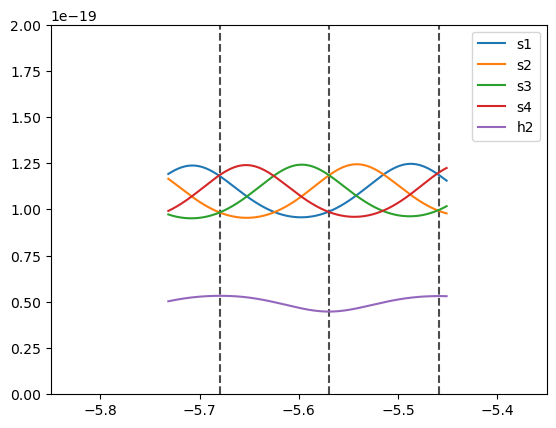

222 230 227 223
229 224 220 229


In [2]:
_, h1, h2, h3, h4, s1, s2, s3, s4 = get_h([1,1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096)

inds = [3150,4300]
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s1[inds[0]:inds[1]]), label='s1')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s2[inds[0]:inds[1]]), label='s2')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s3[inds[0]:inds[1]]), label='s3')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s4[inds[0]:inds[1]]), label='s4')
plt.plot(h2.sample_times[inds[0]:inds[1]], abs(h2[inds[0]:inds[1]])*2, label='h2')
peakh2_ind = np.argmax(abs(h2[inds[0]:inds[1]]))
peakh2_ind2 = np.argmax(abs(h2[inds[1]-int(np.diff(inds)[0]/2):inds[1]]))
minh2_ind = np.argmin(abs(h2[inds[0]:inds[1]]))
plt.axvline(h2.sample_times[inds[0]+peakh2_ind], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.axvline(h2.sample_times[inds[1]-int(np.diff(inds)[0]/2)+peakh2_ind2], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.axvline(h2.sample_times[inds[0]+minh2_ind], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.ylim(0e-19,2e-19)
plt.xlim(-5.85,-5.35)
plt.legend()
plt.show()

peak1_ind1 = np.argmax(abs(s1[inds[0]:inds[1]-int(np.diff(inds)[0]/2)]))
peak1_ind2 = np.argmax(abs(s1[inds[1]-int(np.diff(inds)[0]/2):inds[1]])) - inds[0] - int(np.diff(inds)[0]/2) + inds[1]
peak2_ind = np.argmax(abs(s2[inds[0]:inds[1]]))
peak3_ind = np.argmax(abs(s3[inds[0]:inds[1]]))
peak4_ind = np.argmax(abs(s4[inds[0]:inds[1]]))
min1_ind = np.argmin(abs(s1[inds[0]:inds[1]]))
min2_ind = np.argmin(abs(s2[inds[0]:inds[1]]))
min3_ind1 = np.argmin(abs(s3[inds[0]:inds[1]-int(np.diff(inds)[0]/2)]))
min3_ind2 = np.argmin(abs(s3[inds[1]-int(np.diff(inds)[0]/2):inds[1]])) - inds[0] - int(np.diff(inds)[0]/2) + inds[1]
min4_ind = np.argmin(abs(s4[inds[0]:inds[1]]))
print(peak4_ind - peak1_ind1, peak3_ind - peak4_ind, peak2_ind - peak3_ind, peak1_ind2 - peak2_ind)
print(min2_ind - min3_ind1, min1_ind - min2_ind, min4_ind - min1_ind, min3_ind2 - min4_ind)

Now let's shift 3pi/2 backwards and repeat.

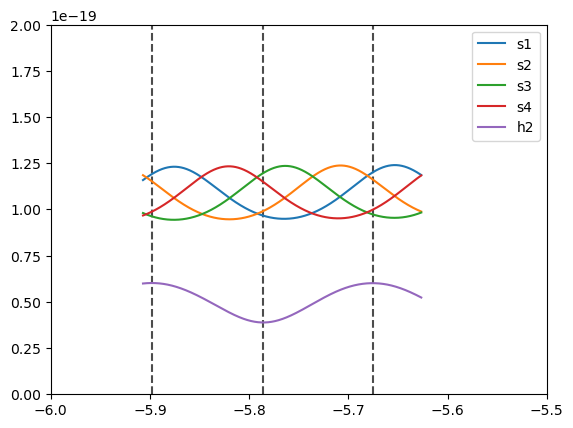

225 233 229 224
230 226 223 232


In [128]:
shift_2pi = 10 - shifted_f(10, 0.1, chirp2total(24, 2), 2)
s_f = 10 - (3*shift_2pi/4)
s_e = shifted_e(s_f, 10, 0.1)
_, h1, h2, h3, h4, s1, s2, s3, s4 = get_h([1,1,1,1], s_f, s_e, chirp2total(24, 2), 2, 4096)

inds = [3150,4300]
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s1[inds[0]:inds[1]]), label='s1')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s2[inds[0]:inds[1]]), label='s2')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s3[inds[0]:inds[1]]), label='s3')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s4[inds[0]:inds[1]]), label='s4')
plt.plot(h2.sample_times[inds[0]:inds[1]], abs(h2[inds[0]:inds[1]])*2, label='h2')
peakh2_ind = np.argmax(abs(h2[inds[0]:inds[1]]))
peakh2_ind2 = np.argmax(abs(h2[inds[1]-int(np.diff(inds)[0]/2):inds[1]]))
minh2_ind = np.argmin(abs(h2[inds[0]:inds[1]]))
plt.axvline(h2.sample_times[inds[0]+peakh2_ind], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.axvline(h2.sample_times[inds[1]-int(np.diff(inds)[0]/2)+peakh2_ind2], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.axvline(h2.sample_times[inds[0]+minh2_ind], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.ylim(0e-19,2e-19)
plt.xlim(-6,-5.5)
plt.legend()
plt.show()

peak1_ind1 = np.argmax(abs(s1[inds[0]:inds[1]-int(np.diff(inds)[0]/2)]))
peak1_ind2 = np.argmax(abs(s1[inds[1]-int(np.diff(inds)[0]/2):inds[1]])) - inds[0] - int(np.diff(inds)[0]/2) + inds[1]
peak2_ind = np.argmax(abs(s2[inds[0]:inds[1]]))
peak3_ind = np.argmax(abs(s3[inds[0]:inds[1]]))
peak4_ind = np.argmax(abs(s4[inds[0]:inds[1]]))
min1_ind = np.argmin(abs(s1[inds[0]:inds[1]]))
min2_ind = np.argmin(abs(s2[inds[0]:inds[1]]))
min3_ind1 = np.argmin(abs(s3[inds[0]:inds[1]-int(np.diff(inds)[0]/2)]))
min3_ind2 = np.argmin(abs(s3[inds[1]-int(np.diff(inds)[0]/2):inds[1]])) - inds[0] - int(np.diff(inds)[0]/2) + inds[1]
min4_ind = np.argmin(abs(s4[inds[0]:inds[1]]))
print(peak4_ind - peak1_ind1, peak3_ind - peak4_ind, peak2_ind - peak3_ind, peak1_ind2 - peak2_ind)
print(min2_ind - min3_ind1, min1_ind - min2_ind, min4_ind - min1_ind, min3_ind2 - min4_ind)

Although (relative) differences between peaks has changed very little, amplitude of h2 envelope modulations has increased significantly.

In both cases, one pattern emerges. The minimum of h2's amplitude modulations occurs at the point where the component minimum's are closest together compare to the peaks at the same point, and vice versa for the h2 peak amplitude modulation. Would naively expect these differences in peak/minimum distance to be shifted back with the component waveforms (and so h2 should also be shifted back), however the above example shows that small differences can occur, changing the location of h2 ampltiude modulations relative to its components.

This is however based on a sample size of 2, so lets choose different parameters: e=0.15, chirp=15, and repeat.

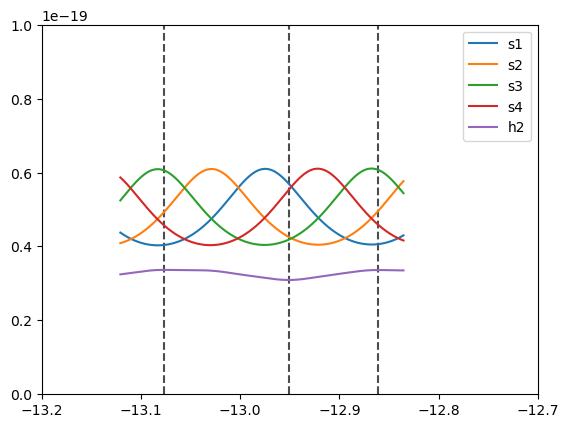

222 222 217 222
217 223 222 221


In [131]:
_, h1, h2, h3, h4, s1, s2, s3, s4 = get_h([1,1,1,1], 10, 0.15, chirp2total(15, 2), 2, 4096)

inds = [3430, 4600]
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s1[inds[0]:inds[1]]), label='s1')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s2[inds[0]:inds[1]]), label='s2')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s3[inds[0]:inds[1]]), label='s3')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s4[inds[0]:inds[1]]), label='s4')
plt.plot(h2.sample_times[inds[0]:inds[1]], abs(h2[inds[0]:inds[1]])*2, label='h2')
peakh2_ind = np.argmax(abs(h2[inds[0]:inds[1]]))
peakh2_ind2 = np.argmax(abs(h2[inds[1]-int(np.diff(inds)[0]/2):inds[1]]))
minh2_ind = np.argmin(abs(h2[inds[0]:inds[1]]))
plt.axvline(h2.sample_times[inds[0]+peakh2_ind], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.axvline(h2.sample_times[inds[1]-int(np.diff(inds)[0]/2)+peakh2_ind2], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.axvline(h2.sample_times[inds[0]+minh2_ind], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.ylim(0e-19,1e-19)
plt.xlim(-13.2,-12.7)
plt.legend()
plt.show()

peak1_ind = np.argmax(abs(s1[inds[0]:inds[1]]))
peak2_ind = np.argmax(abs(s2[inds[0]:inds[1]]))
peak3_ind1 = np.argmax(abs(s3[inds[0]:inds[1]-int(np.diff(inds)[0]/2)]))
peak3_ind2 = np.argmax(abs(s3[inds[1]-int(np.diff(inds)[0]/2):inds[1]])) - inds[0] - int(np.diff(inds)[0]/2) + inds[1]
peak4_ind = np.argmax(abs(s4[inds[0]:inds[1]]))
min1_ind1 = np.argmin(abs(s1[inds[0]:inds[1]-int(np.diff(inds)[0]/2)]))
min1_ind2 = np.argmin(abs(s1[inds[1]-int(np.diff(inds)[0]/2):inds[1]])) - inds[0] - int(np.diff(inds)[0]/2) + inds[1]
min2_ind = np.argmin(abs(s2[inds[0]:inds[1]]))
min3_ind = np.argmin(abs(s3[inds[0]:inds[1]]))
min4_ind = np.argmin(abs(s4[inds[0]:inds[1]]))
print(peak2_ind - peak3_ind1, peak1_ind - peak2_ind, peak4_ind - peak1_ind, peak3_ind2 - peak4_ind)
print(min4_ind - min1_ind1, min3_ind - min4_ind, min2_ind - min3_ind, min1_ind2 - min2_ind)

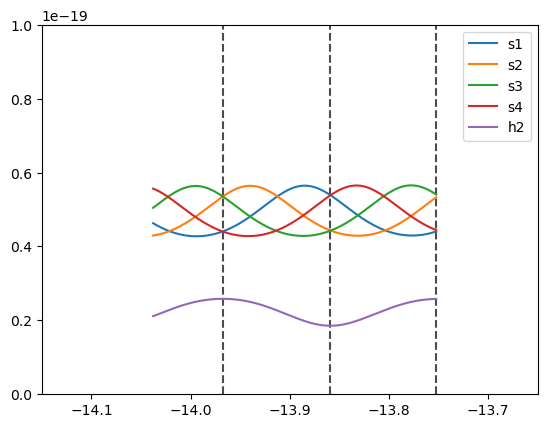

226 225 213 227
214 227 225 224


In [133]:
shift_2pi = 10 - shifted_f(10, 0.15, chirp2total(15, 2), 2)
s_f = 10 - (3*shift_2pi/4)
s_e = shifted_e(s_f, 10, 0.1)
_, h1, h2, h3, h4, s1, s2, s3, s4 = get_h([1,1,1,1], s_f, s_e, chirp2total(15, 2), 2, 4096)

inds = [3430, 4600]
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s1[inds[0]:inds[1]]), label='s1')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s2[inds[0]:inds[1]]), label='s2')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s3[inds[0]:inds[1]]), label='s3')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s4[inds[0]:inds[1]]), label='s4')
plt.plot(h2.sample_times[inds[0]:inds[1]], abs(h2[inds[0]:inds[1]])*2, label='h2')
peakh2_ind = np.argmax(abs(h2[inds[0]:inds[1]]))
peakh2_ind2 = np.argmax(abs(h2[inds[1]-int(np.diff(inds)[0]/2):inds[1]]))
minh2_ind = np.argmin(abs(h2[inds[0]:inds[1]]))
plt.axvline(h2.sample_times[inds[0]+peakh2_ind], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.axvline(h2.sample_times[inds[1]-int(np.diff(inds)[0]/2)+peakh2_ind2], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.axvline(h2.sample_times[inds[0]+minh2_ind], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.ylim(0e-19,1e-19)
plt.xlim(-14.15,-13.65)
plt.legend()
plt.show()

peak1_ind = np.argmax(abs(s1[inds[0]:inds[1]]))
peak2_ind = np.argmax(abs(s2[inds[0]:inds[1]]))
peak3_ind1 = np.argmax(abs(s3[inds[0]:inds[1]-int(np.diff(inds)[0]/2)]))
peak3_ind2 = np.argmax(abs(s3[inds[1]-int(np.diff(inds)[0]/2):inds[1]])) - inds[0] - int(np.diff(inds)[0]/2) + inds[1]
peak4_ind = np.argmax(abs(s4[inds[0]:inds[1]]))
min1_ind1 = np.argmin(abs(s1[inds[0]:inds[1]-int(np.diff(inds)[0]/2)]))
min1_ind2 = np.argmin(abs(s1[inds[1]-int(np.diff(inds)[0]/2):inds[1]])) - inds[0] - int(np.diff(inds)[0]/2) + inds[1]
min2_ind = np.argmin(abs(s2[inds[0]:inds[1]]))
min3_ind = np.argmin(abs(s3[inds[0]:inds[1]]))
min4_ind = np.argmin(abs(s4[inds[0]:inds[1]]))
print(peak2_ind - peak3_ind1, peak1_ind - peak2_ind, peak4_ind - peak1_ind, peak3_ind2 - peak4_ind)
print(min4_ind - min1_ind1, min3_ind - min4_ind, min2_ind - min3_ind, min1_ind2 - min2_ind)

Same pattern in these two plots but reversed - when peaks are closer together, see minimum in h2 amp modulations and vice versa. We can also see here that when the (relative) peak/minimum distances increase, the h2 amplitude modulations also increase.

It is clear now that the amplitude modulations in h2 (and possibly the other waveforms as well) are not 'physical' but rather a result of inexact shifting of the component waveforms. Can think of two possible solutions. One is to attempt to improving the component waveform shifting such that the modulations in these waveforms disappear (or become at least negligible). Second would be to accept that inaccuracies will be present, and deliberately enforce inaccuracy between two component waveforms such that we can shift h1,...,hn simply by shifting the component waveforms.

The first idea is better 'scientifically', however I fear that even removing modulations as much as possible will not remove stripes from ecc^2 against chirp plots as SVD100 h1 still showed stripes of the same magnitude and location despite extremely low modulations. Second idea is therefore a 'back-up' of sorts.

# Non-eccentric waveform test

As a test, let's create an ecc^2 against chirp plot where instead of h1,...,hn at the red dot, we just have the non-eccentric waveform corresponding to this point, found by adjusting the chirp mass along the line of degeneracy (i.e. the same effective chirp mass). As this waveform will have no amplitude modulations, we would hope that there should also be no stripes visible on the plot.

In [134]:
def favata_et_al_avg(given_e, given_chirp, e_vals, f_low=10, q=2):
    """
    Converts array of eccentricity values to chirp mass along a line of constant 
    effective chirp mass, as given by equation 1.1 in Favata et al. 
    https://arxiv.org/pdf/2108.05861.pdf.

    Parameters:
        given_e: Value of eccentricity for given point on line of constant effective chirp mass.
        given_chirp: Value of chirp mass for given point on line of constant effective chirp mass.
        e_vals: Frequency values to be converted.

    Returns:
        Converted chirp mass values.
    """

    # Generate waveform at given point to use in sigmasq
    h = gen_wf(f_low, given_e, chirp2total(given_chirp, q), q, 4096, 'TEOBResumS')
    h.resize(ceiltwo(len(h)))
    
    # Generate the aLIGO ZDHP PSD
    psd, _ = gen_psd(h, f_low)

    # Calculate both integrals using sigmasq
    h = h.real().to_frequencyseries()
    ss = sigmasq(h, psd=psd, low_frequency_cutoff=f_low+3)
    ssf = sigmasq(h*h.sample_frequencies**(-7/3), psd=psd, low_frequency_cutoff=f_low+3)

    # Use average frequency to evolve eccentricities
    avg_f = (ssf/ss)**(-3/14)
    print('Average frequency: '+str(avg_f)+' Hz')
    s_given_e = shifted_e(avg_f, f_low, given_e)
    print(f'Given_e shifted from {given_e} to {s_given_e}')
    s_e_vals = shifted_e(avg_f, f_low, e_vals)

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-(157/24)*s_given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-(157/24)*s_e_vals**2)**(3/5)

    return chirp_vals

Let's compare the non-eccentric waveform with h1 to see similarity.

Average frequency: 29.736871508999076 Hz
Given_e shifted from 0.1 to 0.03165268397273404


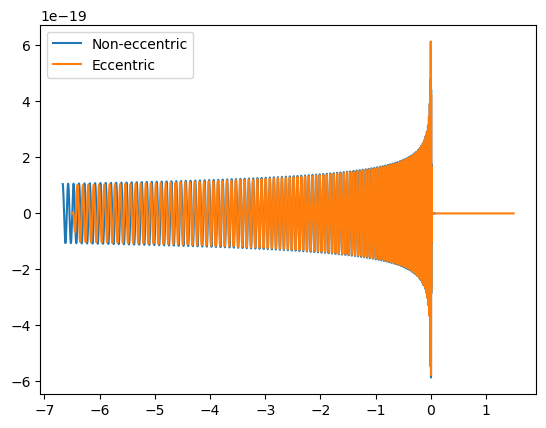

In [138]:
non_ecc_chirp = favata_et_al_avg(0.1, 24, 0)
h = gen_wf(10, 0, chirp2total(non_ecc_chirp, 2), 2, 4096, 'TEOBResumS')
_, h1, _, _, _, _, _, _, _ = get_h([1,1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096)
plt.plot(h.sample_times, h, label='Non-eccentric')
plt.plot(h1.sample_times, h1, label='Eccentric')
plt.legend()

Phases are slightly different, but can easily see that envelope is almost identical between the waveforms. Now let's make our ecc^2 against chirp mass plot.

In [144]:
# Calculates matches to a fiducial h1, h2 waveform over a grid of eccentricity against chirp mass
def ecc_chirp_match_non_ecc(e_vals, chirp_vals, fiducials, f_low, approximant='TEOBResumS'):

    # Setup match dict and calculate conversion from chirp to total mass
    matches = {'match':[], 'match_angle':[]}

    # Generate fiducial waveform
    non_ecc_chirp = favata_et_al_avg(fiducials[0], fiducials[1], 0)
    non_ecc_wf = gen_wf(f_low, 0, chirp2total(non_ecc_chirp, fiducials[2]), fiducials[2], 4096, 'TEOBResumS')

    # Progress bar setup
    progress = 0
    gridsize = len(e_vals)*len(chirp_vals)

    # Loop over eccentricity values
    for e in e_vals:
        matches['match'].append([])
        matches['match_angle'].append([])

        # Loop over chirp mass values
        for chirp in chirp_vals:

            # Calculate match
            s = gen_wf(f_low, e, chirp2total(chirp, fiducials[2]), fiducials[2], 4096, approximant=approximant)
            match, match_angle = match_wfs(non_ecc_wf, s, f_low, True, return_phase=True)

            # Save matches
            matches['match'][-1].append(match)
            matches['match_angle'][-1].append(match_angle)

            # Progress bar
            progress += 1
            print('\r' + f'{progress} done out of {gridsize}', end='')

    return matches

In [151]:
# Plots match contours on eccentricity/chirp mass plot
def ecc_chirp_plot_non_ecc(e_vals, chirp_vals, fiducials, matches):

    # Convert to eccentricity squared
    e2_vals = e_vals**2
    
    # Plotting amplitude contour
    plt.contourf(chirp_vals, e2_vals, matches['match'], np.linspace(0.8, 1, 15), vmin=0.8, vmax=1, extend='min')
    plt.colorbar(label='match')
    plt.contour(chirp_vals, e2_vals, matches['match'], [0.97], colors=['C1'])
    plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
    non_ecc_chirp = favata_et_al_avg(fiducials[0], fiducials[1], 0)
    plt.scatter(non_ecc_chirp, 0, c='r', zorder=5)
    plt.plot(favata_et_al_avg(fiducials[0], fiducials[1], e_vals), e2_vals, c='m')
    plt.xlabel('$\mathcal{M}~/~M_\odot$')
    plt.ylabel('$e^2$')
    plt.title(f'match, q={fiducials[2]}')
    plt.show()

    # phase
    plt.contourf(chirp_vals, e2_vals, matches['match_angle'], cmap='twilight_shifted')
    plt.colorbar(label='phase of complex overlap')
    plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
    plt.xlabel('$\mathcal{M}~/~M_\odot$')
    plt.ylabel('$e^2$')
    plt.title(f'match angle, q={fiducials[2]}')
    plt.show()

    # cos(phase)
    plt.contourf(chirp_vals, e2_vals, np.cos(matches['match_angle']))
    plt.colorbar(label='cos(phase) of complex overlap')
    plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
    plt.xlabel('$\mathcal{M}~/~M_\odot$')
    plt.ylabel('$e^2$')
    plt.title(f'match angle (cos), q={fiducials[2]}')
    plt.show()

In [145]:
e_vals_0 = np.linspace(0, 0.2, 31)
chirp_vals_0 = np.linspace(23, 25, 31)
start = time.time()
dataslot_0 = ecc_chirp_match_non_ecc(e_vals_0, chirp_vals_0, [0.1, 24, 2], 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

Average frequency: 29.736871508999076 Hz
Given_e shifted from 0.1 to 0.03165268397273404
961 done out of 961
Time taken: 1233.2773530483246 seconds


Average frequency: 29.736871508999076 Hz
Given_e shifted from 0.1 to 0.03165268397273404
Average frequency: 29.736871508999076 Hz
Given_e shifted from 0.1 to 0.03165268397273404


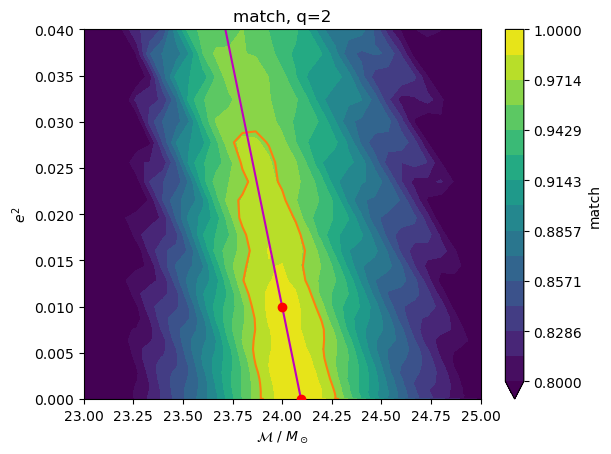

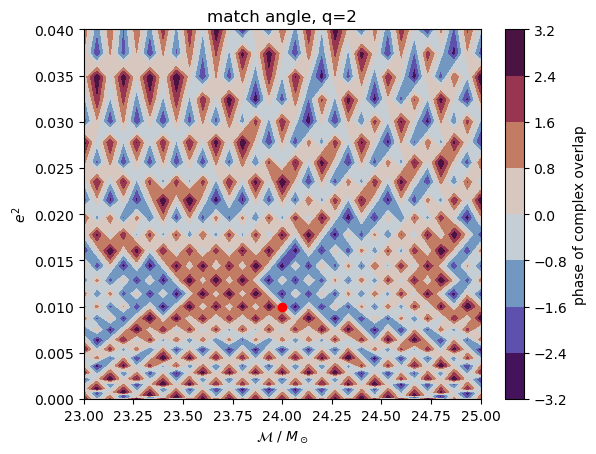

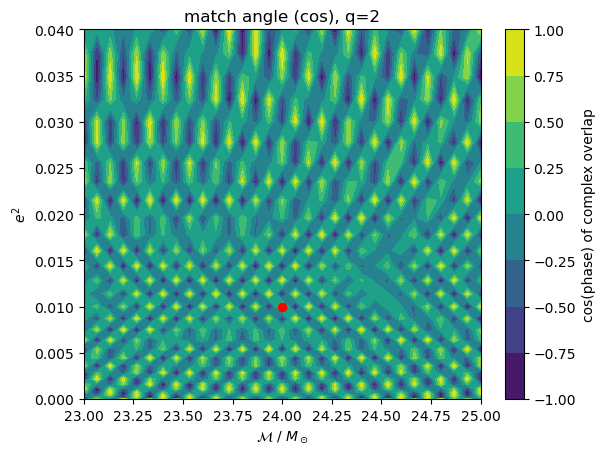

In [152]:
ecc_chirp_plot_non_ecc(e_vals_0, chirp_vals_0,  [0.1, 24, 2], dataslot_0)

The stripes are therefore still present, even when the fiducial waveform has no amplitude modulations. This is rather puzzling.

In light of this result, I believe the best approach from here is to attempt to reduce the amplitude modulations as much as possible by reducing the inaccuracy in shifted component waveforms. This will clearly not remove the stripes in the above plot by itself, however will hopefully allow the phase difference method to work effectively to remove them.

# Testing component shift correction

Idea is to improve component shifting by generating a prelimary trial waveform 2pi back in true anomaly from the first (unshifted) component waveform, as calculated by the shifted_f, shifted_e equations. Can then compare positions of the first peak to calculate correction required to actually get 2pi in true anomaly, and use this to generate the shifts required for component waveforms.

Let's test this by recreating a plot where we calculated distances between amplitude modulation peaks/minimums.

9.867789026114005
1437.0
1428


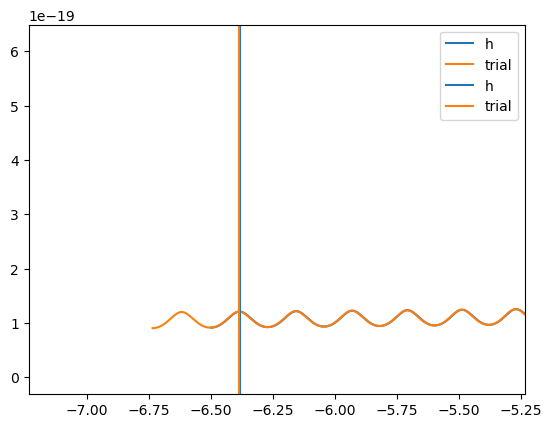

9.869027214214915
1428.0
1428


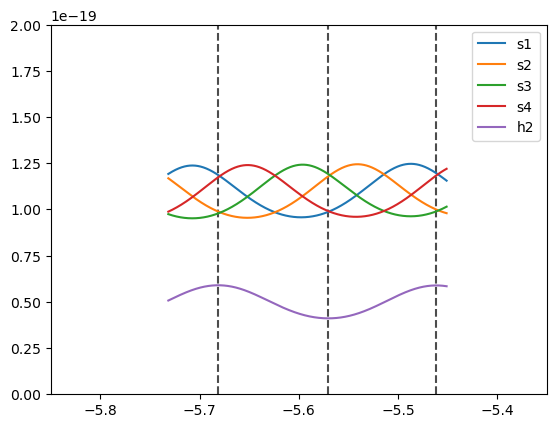

229 227 226 220
227 222 227 226


In [2]:
_, h1, h2, h3, h4, s1, s2, s3, s4 = get_h([1,1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096, comp_shift_corr=True)

inds = [3150,4300]
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s1[inds[0]:inds[1]]), label='s1')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s2[inds[0]:inds[1]]), label='s2')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s3[inds[0]:inds[1]]), label='s3')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s4[inds[0]:inds[1]]), label='s4')
plt.plot(h2.sample_times[inds[0]:inds[1]], abs(h2[inds[0]:inds[1]])*2, label='h2')
peakh2_ind = np.argmax(abs(h2[inds[0]:inds[1]]))
peakh2_ind2 = np.argmax(abs(h2[inds[1]-int(np.diff(inds)[0]/2):inds[1]]))
minh2_ind = np.argmin(abs(h2[inds[0]:inds[1]]))
plt.axvline(h2.sample_times[inds[0]+peakh2_ind], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.axvline(h2.sample_times[inds[1]-int(np.diff(inds)[0]/2)+peakh2_ind2], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.axvline(h2.sample_times[inds[0]+minh2_ind], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.ylim(0e-19,2e-19)
plt.xlim(-5.85,-5.35)
plt.legend()
plt.show()

peak1_ind1 = np.argmax(abs(s1[inds[0]:inds[1]-int(np.diff(inds)[0]/2)]))
peak1_ind2 = np.argmax(abs(s1[inds[1]-int(np.diff(inds)[0]/2):inds[1]])) - inds[0] - int(np.diff(inds)[0]/2) + inds[1]
peak2_ind = np.argmax(abs(s2[inds[0]:inds[1]]))
peak3_ind = np.argmax(abs(s3[inds[0]:inds[1]]))
peak4_ind = np.argmax(abs(s4[inds[0]:inds[1]]))
min1_ind = np.argmin(abs(s1[inds[0]:inds[1]]))
min2_ind = np.argmin(abs(s2[inds[0]:inds[1]]))
min3_ind1 = np.argmin(abs(s3[inds[0]:inds[1]-int(np.diff(inds)[0]/2)]))
min3_ind2 = np.argmin(abs(s3[inds[1]-int(np.diff(inds)[0]/2):inds[1]])) - inds[0] - int(np.diff(inds)[0]/2) + inds[1]
min4_ind = np.argmin(abs(s4[inds[0]:inds[1]]))
print(peak4_ind - peak1_ind1, peak3_ind - peak4_ind, peak2_ind - peak3_ind, peak1_ind2 - peak2_ind)
print(min2_ind - min3_ind1, min1_ind - min2_ind, min4_ind - min1_ind, min3_ind2 - min4_ind)

9.772046244812485
1451.0
1440


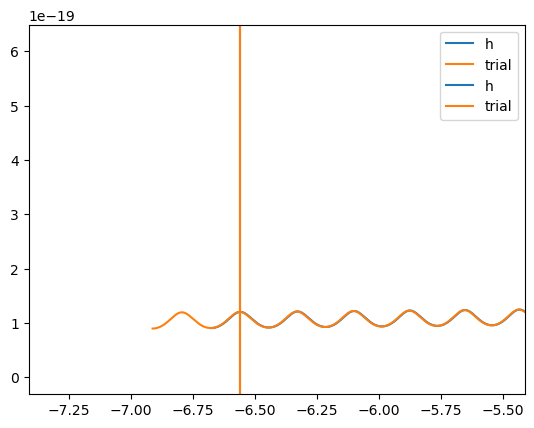

9.773505308429893
1439.0
1440


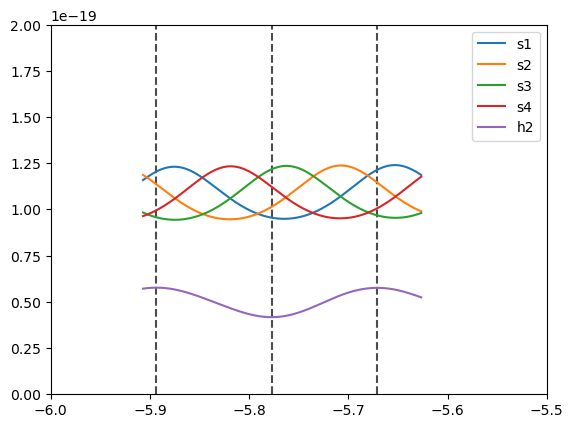

233 230 226 222
227 224 231 229


In [3]:
shift_2pi = 10 - shifted_f(10, 0.1, chirp2total(24, 2), 2)
s_f = 10 - (3*shift_2pi/4)
s_e = shifted_e(s_f, 10, 0.1)
_, h1, h2, h3, h4, s1, s2, s3, s4 = get_h([1,1,1,1], s_f, s_e, chirp2total(24, 2), 2, 4096, comp_shift_corr=True)

inds = [3150,4300]
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s1[inds[0]:inds[1]]), label='s1')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s2[inds[0]:inds[1]]), label='s2')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s3[inds[0]:inds[1]]), label='s3')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s4[inds[0]:inds[1]]), label='s4')
plt.plot(h2.sample_times[inds[0]:inds[1]], abs(h2[inds[0]:inds[1]])*2, label='h2')
peakh2_ind = np.argmax(abs(h2[inds[0]:inds[1]]))
peakh2_ind2 = np.argmax(abs(h2[inds[1]-int(np.diff(inds)[0]/2):inds[1]]))
minh2_ind = np.argmin(abs(h2[inds[0]:inds[1]]))
plt.axvline(h2.sample_times[inds[0]+peakh2_ind], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.axvline(h2.sample_times[inds[1]-int(np.diff(inds)[0]/2)+peakh2_ind2], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.axvline(h2.sample_times[inds[0]+minh2_ind], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.ylim(0e-19,2e-19)
plt.xlim(-6,-5.5)
plt.legend()
plt.show()

peak1_ind1 = np.argmax(abs(s1[inds[0]:inds[1]-int(np.diff(inds)[0]/2)]))
peak1_ind2 = np.argmax(abs(s1[inds[1]-int(np.diff(inds)[0]/2):inds[1]])) - inds[0] - int(np.diff(inds)[0]/2) + inds[1]
peak2_ind = np.argmax(abs(s2[inds[0]:inds[1]]))
peak3_ind = np.argmax(abs(s3[inds[0]:inds[1]]))
peak4_ind = np.argmax(abs(s4[inds[0]:inds[1]]))
min1_ind = np.argmin(abs(s1[inds[0]:inds[1]]))
min2_ind = np.argmin(abs(s2[inds[0]:inds[1]]))
min3_ind1 = np.argmin(abs(s3[inds[0]:inds[1]-int(np.diff(inds)[0]/2)]))
min3_ind2 = np.argmin(abs(s3[inds[1]-int(np.diff(inds)[0]/2):inds[1]])) - inds[0] - int(np.diff(inds)[0]/2) + inds[1]
min4_ind = np.argmin(abs(s4[inds[0]:inds[1]]))
print(peak4_ind - peak1_ind1, peak3_ind - peak4_ind, peak2_ind - peak3_ind, peak1_ind2 - peak2_ind)
print(min2_ind - min3_ind1, min1_ind - min2_ind, min4_ind - min1_ind, min3_ind2 - min4_ind)

This method does not appear to work very well - although we are able to 'correct' the shifting of the preliminary trial waveform, the distance between peaks of the component waveforms remains unchanged. Will change functionality now (so above plots may not reflect actual results if reran), such that all components beyond first are generated as trials, distances calculated as in these plots, and these distances used to inform necessary corrections. Will take longer as n-1 teob calls required instead of 1, but will hopefully work better.

3.0 2.5


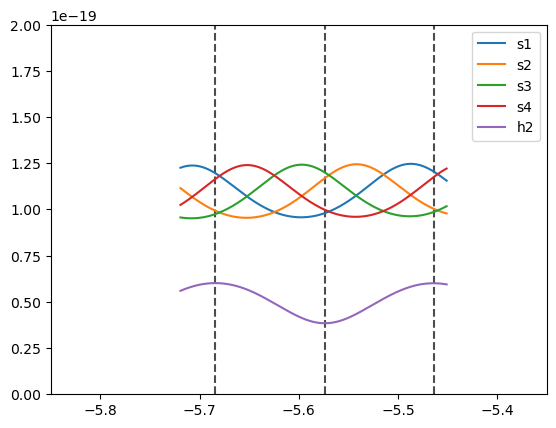

227 225 226 224
228 225 225 224


In [2]:
_, h1, h2, h3, h4, s1, s2, s3, s4 = get_h([1,1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096, comp_shift_corr=True)

inds = [3200,4300]
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s1[inds[0]:inds[1]]), label='s1')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s2[inds[0]:inds[1]]), label='s2')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s3[inds[0]:inds[1]]), label='s3')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s4[inds[0]:inds[1]]), label='s4')
plt.plot(h2.sample_times[inds[0]:inds[1]], abs(h2[inds[0]:inds[1]])*2, label='h2')
peakh2_ind = np.argmax(abs(h2[inds[0]:inds[1]]))
peakh2_ind2 = np.argmax(abs(h2[inds[1]-int(np.diff(inds)[0]/2):inds[1]]))
minh2_ind = np.argmin(abs(h2[inds[0]:inds[1]]))
plt.axvline(h2.sample_times[inds[0]+peakh2_ind], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.axvline(h2.sample_times[inds[1]-int(np.diff(inds)[0]/2)+peakh2_ind2], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.axvline(h2.sample_times[inds[0]+minh2_ind], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.ylim(0e-19,2e-19)
plt.xlim(-5.85,-5.35)
plt.legend()
plt.show()

peak1_ind1 = np.argmax(abs(s1[inds[0]:inds[1]-int(np.diff(inds)[0]/2)]))
peak1_ind2 = np.argmax(abs(s1[inds[1]-int(np.diff(inds)[0]/2):inds[1]])) - inds[0] - int(np.diff(inds)[0]/2) + inds[1]
peak2_ind = np.argmax(abs(s2[inds[0]:inds[1]]))
peak3_ind = np.argmax(abs(s3[inds[0]:inds[1]]))
peak4_ind = np.argmax(abs(s4[inds[0]:inds[1]]))
min1_ind = np.argmin(abs(s1[inds[0]:inds[1]]))
min2_ind = np.argmin(abs(s2[inds[0]:inds[1]]))
min3_ind1 = np.argmin(abs(s3[inds[0]:inds[1]-int(np.diff(inds)[0]/2)]))
min3_ind2 = np.argmin(abs(s3[inds[1]-int(np.diff(inds)[0]/2):inds[1]])) - inds[0] - int(np.diff(inds)[0]/2) + inds[1]
min4_ind = np.argmin(abs(s4[inds[0]:inds[1]]))
print(peak4_ind - peak1_ind1, peak3_ind - peak4_ind, peak2_ind - peak3_ind, peak1_ind2 - peak2_ind)
print(min2_ind - min3_ind1, min1_ind - min2_ind, min4_ind - min1_ind, min3_ind2 - min4_ind)

2.5 2.0


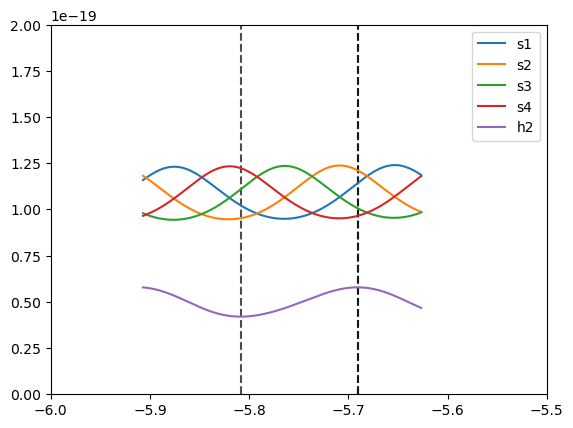

229 228 226 228
228 230 227 226


In [3]:
shift_2pi = 10 - shifted_f(10, 0.1, chirp2total(24, 2), 2)
s_f = 10 - (3*shift_2pi/4)
s_e = shifted_e(s_f, 10, 0.1)
_, h1, h2, h3, h4, s1, s2, s3, s4 = get_h([1,1,1,1], s_f, s_e, chirp2total(24, 2), 2, 4096, comp_shift_corr=True)

inds = [3150,4300]
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s1[inds[0]:inds[1]]), label='s1')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s2[inds[0]:inds[1]]), label='s2')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s3[inds[0]:inds[1]]), label='s3')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s4[inds[0]:inds[1]]), label='s4')
plt.plot(h2.sample_times[inds[0]:inds[1]], abs(h2[inds[0]:inds[1]])*2, label='h2')
peakh2_ind = np.argmax(abs(h2[inds[0]:inds[1]]))
peakh2_ind2 = np.argmax(abs(h2[inds[1]-int(np.diff(inds)[0]/2):inds[1]]))
minh2_ind = np.argmin(abs(h2[inds[0]:inds[1]]))
plt.axvline(h2.sample_times[inds[0]+peakh2_ind], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.axvline(h2.sample_times[inds[1]-int(np.diff(inds)[0]/2)+peakh2_ind2], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.axvline(h2.sample_times[inds[0]+minh2_ind], c='k', ls='dashed', zorder=-1, alpha=0.7)
plt.ylim(0e-19,2e-19)
plt.xlim(-6,-5.5)
plt.legend()
plt.show()

peak1_ind1 = np.argmax(abs(s1[inds[0]:inds[1]-int(np.diff(inds)[0]/2)]))
peak1_ind2 = np.argmax(abs(s1[inds[1]-int(np.diff(inds)[0]/2):inds[1]])) - inds[0] - int(np.diff(inds)[0]/2) + inds[1]
peak2_ind = np.argmax(abs(s2[inds[0]:inds[1]]))
peak3_ind = np.argmax(abs(s3[inds[0]:inds[1]]))
peak4_ind = np.argmax(abs(s4[inds[0]:inds[1]]))
min1_ind = np.argmin(abs(s1[inds[0]:inds[1]]))
min2_ind = np.argmin(abs(s2[inds[0]:inds[1]]))
min3_ind1 = np.argmin(abs(s3[inds[0]:inds[1]-int(np.diff(inds)[0]/2)]))
min3_ind2 = np.argmin(abs(s3[inds[1]-int(np.diff(inds)[0]/2):inds[1]])) - inds[0] - int(np.diff(inds)[0]/2) + inds[1]
min4_ind = np.argmin(abs(s4[inds[0]:inds[1]]))
print(peak4_ind - peak1_ind1, peak3_ind - peak4_ind, peak2_ind - peak3_ind, peak1_ind2 - peak2_ind)
print(min2_ind - min3_ind1, min1_ind - min2_ind, min4_ind - min1_ind, min3_ind2 - min4_ind)

Have also now taken into account orbital evolution effects and does now show significant improvement. Despite this, not only does the true anomaly shifting still not work to shift h2 amplitude modulations but the modulations are also larger, so it is clear we still do not really understand their origin.